In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as PipeIMBL

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, normalize
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import ParameterGrid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import json

import upsetplot as uplt
import vae_utils
# progress bar
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append("../")

import AtlasAnalysisFunctions as AAF
import utils_ML as uml

import shap
shap.initjs()
plt.style.use('seaborn-dark')

In [2]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


In [3]:
# read data

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

data = pd.read_csv("../preprocessing/quantile_norm_NSAF_50.csv", index_col = "assay_id")
with open("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/selected_features.txt", "r") as f:
    features = f.readlines()
    features = [x.strip() for x in features]
data = data.loc[:, features]
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()

class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [4]:
feature_names = data.columns
dataset = data.reset_index(drop=True).rename(columns={data.columns[x]:x for x in range(len(data.columns))})

In [5]:
# Impute and scale
imputer = uml.LowestValueImputerGaussian()
dataset = imputer.fit_transform(dataset,targets)
dataset = MinMaxScaler().fit_transform(dataset)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(dataset, targets,
                                                    stratify=targets, 
                                                    test_size=0.20,
                                                    random_state=42)

# Init
smote = SMOTE()
#vae = vae_utils.VariationalAutoencoder(6, 161, 50)
#vae.load_state_dict(torch.load("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/preprocessing/VAE_model_filtered"))

lr_smote = LogisticRegression(max_iter=10000, C=50, solver="liblinear", penalty="l2")
svc_smote = SVC(C=15, kernel="rbf", probability=True)
rf_smote = RandomForestClassifier(n_estimators = 150, criterion="entropy", max_depth = 10)

# Oversample
smote_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)
#vae_oversampled, y_vae = vae_utils.resampleVAE(vae, X_train.to_numpy().astype("float32"), list(y_train), 10)

# Fit
lr_smote.fit(smote_oversampled, y_oversampled)
svc_smote.fit(smote_oversampled, y_oversampled)
rf_smote.fit(smote_oversampled, y_oversampled)

Y_pred_lr_smote = lr_smote.predict(X_test)
Y_pred_svc_smote = svc_smote.predict(X_test)
Y_pred_rf_smote = rf_smote.predict(X_test)

Show predictions per model

Text(252.5, 0.5, 'True label')

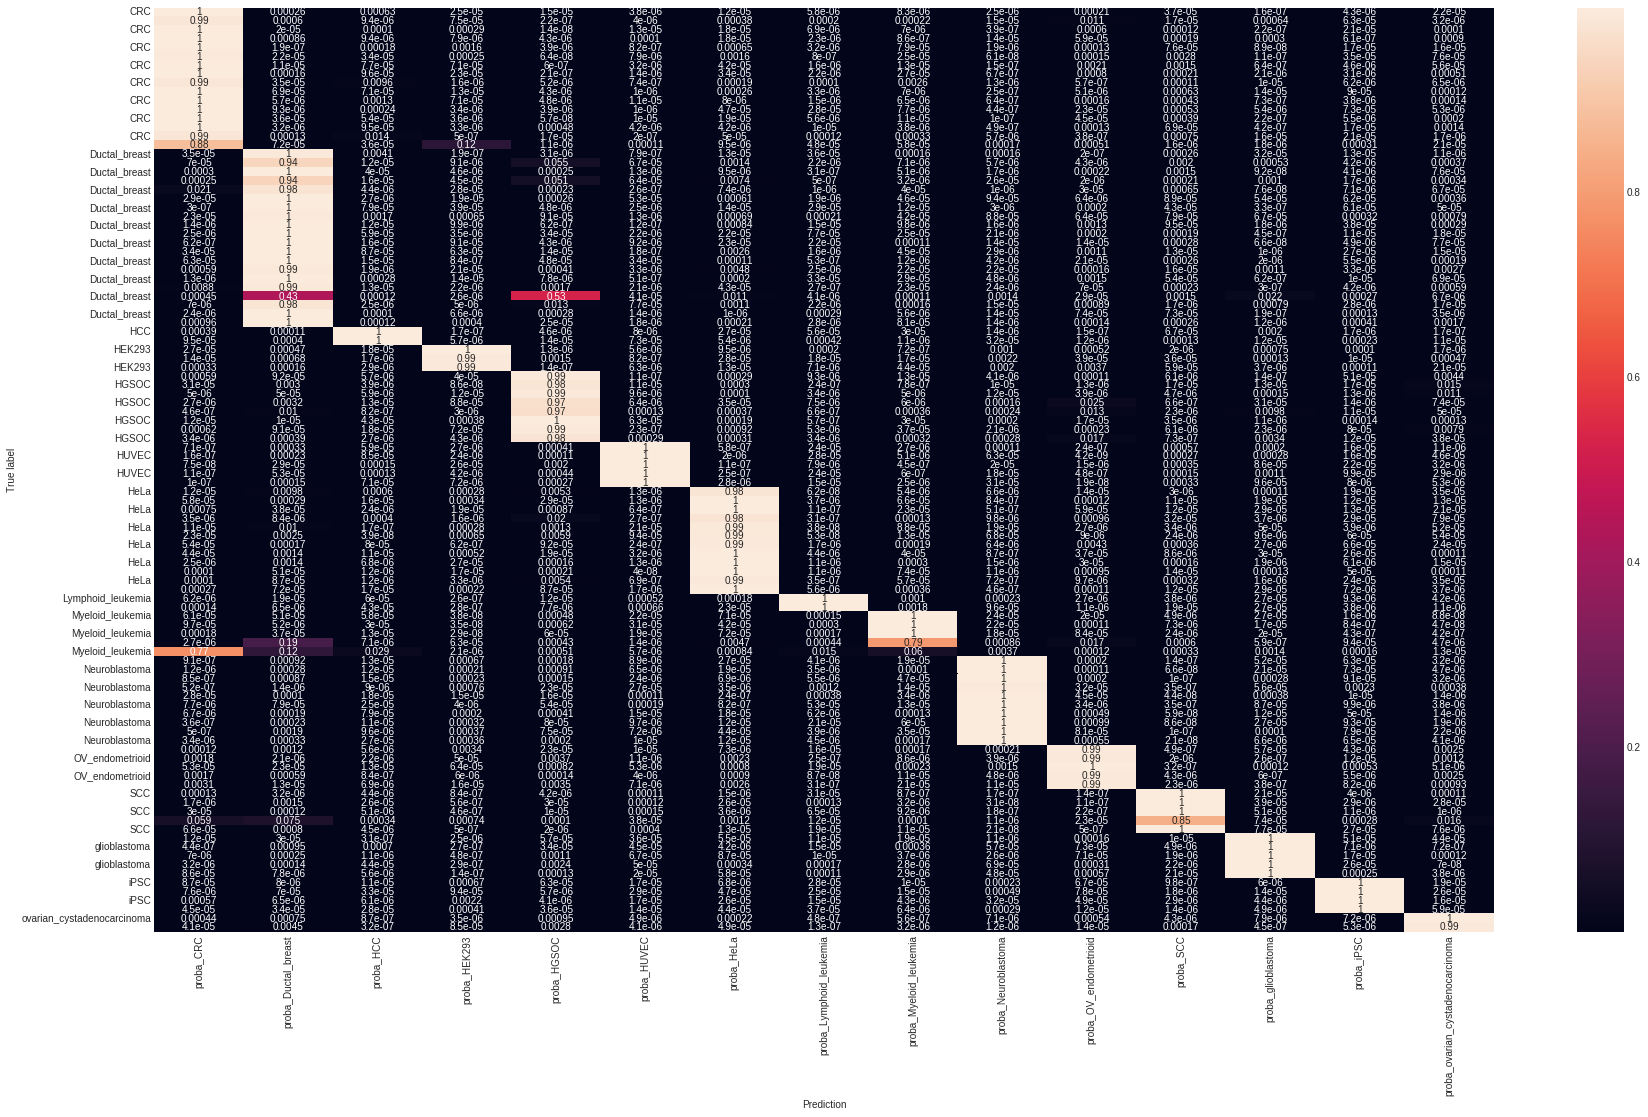

In [16]:
predictions_lr = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_lr_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_lr["correct"] = predictions_lr.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_lr = lr_smote.predict_proba(X_test)
predictions_lr = pd.concat([predictions_lr, pd.DataFrame(proba_predictions_lr, columns = ['proba_'+x for x in target_encoder.inverse_transform(lr_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_lr.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

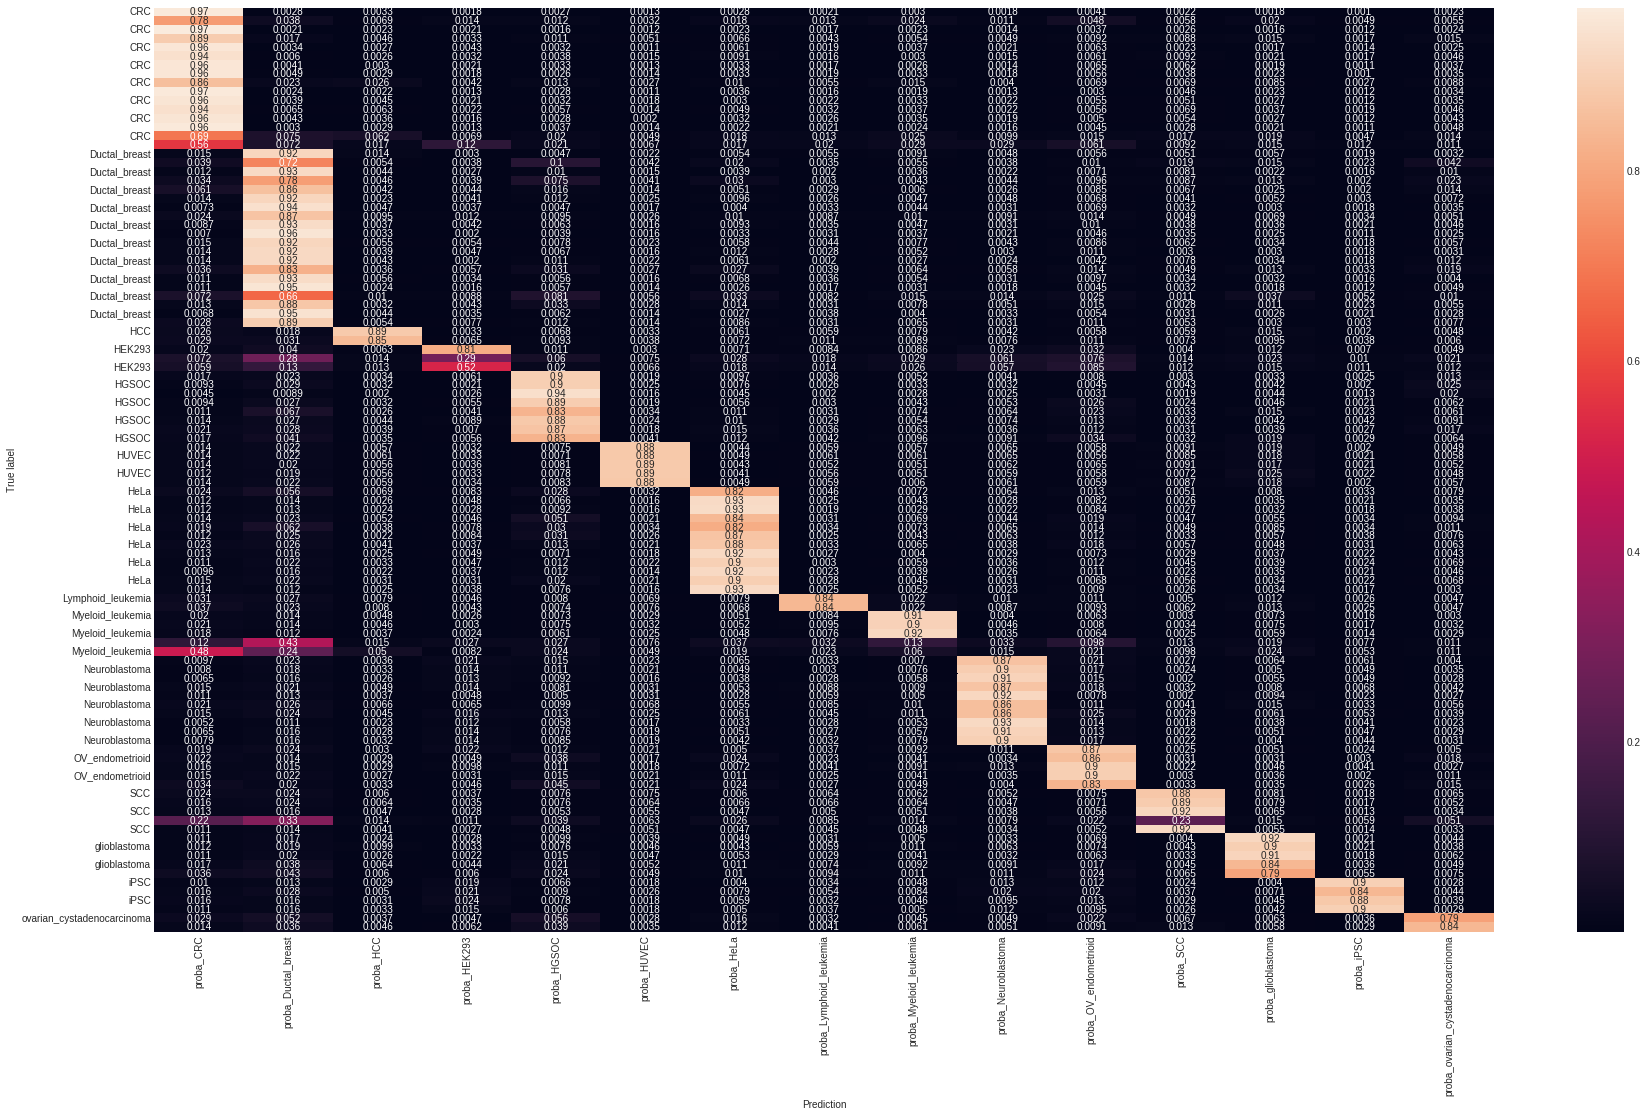

In [17]:
predictions_svc = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_svc_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_svc["correct"] = predictions_svc.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_svc = svc_smote.predict_proba(X_test)
predictions_svc = pd.concat([predictions_svc, pd.DataFrame(proba_predictions_svc, columns = ['proba_'+x for x in target_encoder.inverse_transform(svc_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_svc.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Text(252.5, 0.5, 'True label')

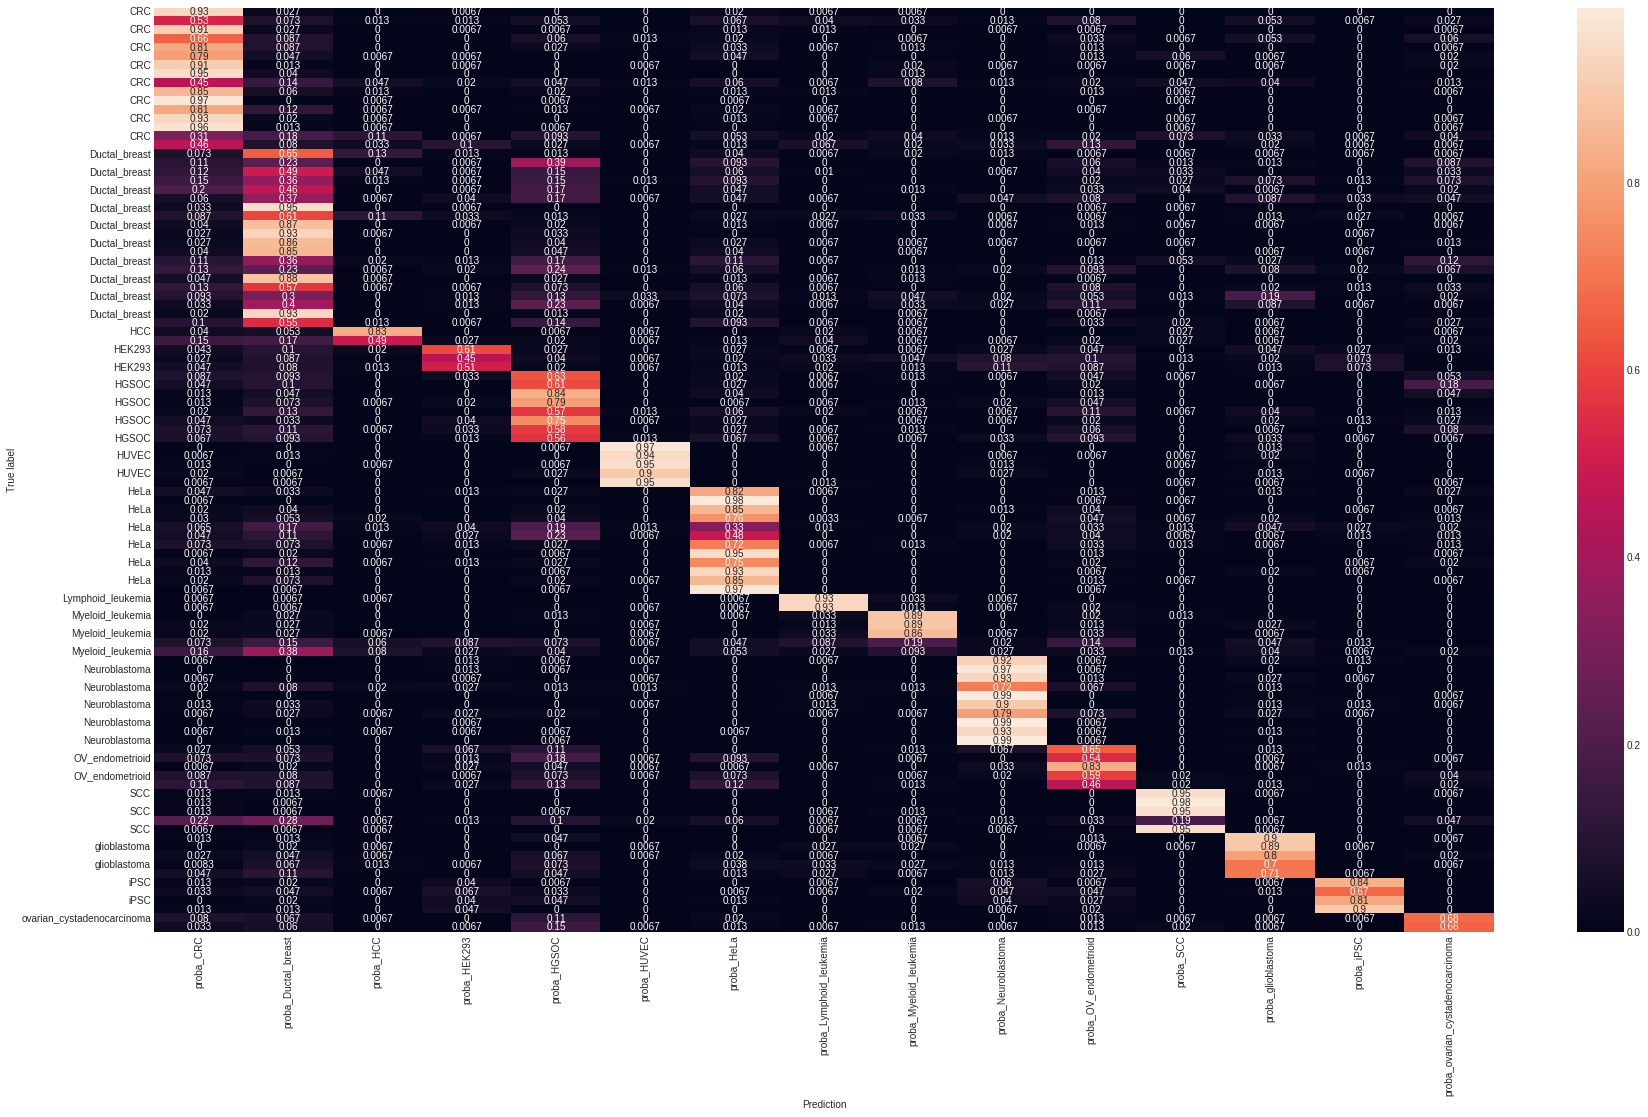

In [18]:
predictions_rf = pd.DataFrame({'prediction': target_encoder.inverse_transform(Y_pred_rf_smote), 'label': target_encoder.inverse_transform(y_test)})
predictions_rf["correct"] = predictions_rf.apply(lambda x: True if x["prediction"] == x["label"] else False, axis=1)
proba_predictions_rf = rf_smote.predict_proba(X_test)
predictions_rf = pd.concat([predictions_rf, pd.DataFrame(proba_predictions_rf, columns = ['proba_'+x for x in target_encoder.inverse_transform(rf_smote.classes_)])], axis = 1)
fig = plt.figure(figsize=(30,17))

s = sns.heatmap(predictions_rf.set_index('label').sort_index().iloc[:,2:], annot = True)
s.set_xlabel('Prediction')
s.set_ylabel('True label')

Get shap values for test set that are correctly predicted

In [19]:
lr_correct_i = predictions_lr[predictions_lr["correct"]].index
svc_correct_i = predictions_svc[predictions_svc["correct"]].index
rf_correct_i = predictions_rf[predictions_rf["correct"]].index

In [20]:
x_lr_correct, y_lr_correct = X_test[lr_correct_i], y_test[lr_correct_i]
x_svc_correct, y_svc_correct = X_test[svc_correct_i], y_test[svc_correct_i]
x_rf_correct, y_rf_correct = X_test[rf_correct_i], y_test[rf_correct_i]

In [25]:
explainer_cpu_lr = shap.LinearExplainer(lr_smote, X_train)
shap_values_lr_test = explainer_cpu_lr.shap_values(x_lr_correct)
shap_values_lr_train = explainer_cpu_lr.shap_values(X_train)
print("LR explained")

LR explained


In [ ]:
explainer_cpu_svc = shap.KernelExplainer(svc_smote.predict_proba, X_train)
shap_values_svc_test = explainer_cpu_svc.shap_values(x_svc_correct)
shap_values_svc_train = explainer_cpu_svc.shap_values(X_train)
print("svc explained")

In [26]:
explainer_cpu_rf = shap.TreeExplainer(rf_smote, X_train)
shap_values_rf_test = explainer_cpu_rf.shap_values(x_rf_correct)
shap_values_rf_train = explainer_cpu_rf.shap_values(X_train)
print("RF explained")

 99%|===================| 6170/6210 [01:51<00:00]        

RF explained


In [28]:
file1 = open("./shap_values/lr_test", "wb")
#file2 = open("./shap_values/svc_test", "wb")
file3 = open("./shap_values/rf_test", "wb")

file4 = open("./shap_values/lr_train", "wb")
#file5 = open("./shap_values/svc_train", "wb")
file6 = open("./shap_values/rf_train", "wb")

np.save(file1, np.array(shap_values_lr_test))
#np.save(file2, np.array(shap_values_svc_test))
np.save(file3, np.array(shap_values_rf_test))

np.save(file4, np.array(shap_values_lr_train))
#np.save(file5, np.array(shap_values_svc_train))
np.save(file6, np.array(shap_values_rf_train))

file1.close
#file2.close
file3.close
file4.close
#file5.close
file6.close

<function BufferedWriter.close>

In [31]:
shap_lr_test = np.load("./shap_values/lr_test")
shap_lr_train = np.load("./shap_values/lr_train")
#shap_svc_test = np.load("./shap_values/svc_test")
#shap_svc_train = np.load("./shap_values/svc_train")
shap_rf_test = np.load("./shap_values/rf_test")
shap_rf_train = np.load("./shap_values/rf_train")

---

Import Gene ontology 

In [7]:
with open("GO_C_uniprot_map.json", 'r') as f:
    uniprot_go_compartment = json.load(f)

with open("GO_F_uniprot_map.json", 'r') as f:
    uniprot_go_function = json.load(f)

with open("GO_P_uniprot_map.json", 'r') as f:
    uniprot_go_process = json.load(f)

In [8]:
GO_description = pd.read_csv("../annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

In [9]:
C_GO_prots = list(uniprot_go_compartment.keys())
F_GO_prots = list(uniprot_go_function.keys())
P_GO_prots = list(uniprot_go_process.keys())

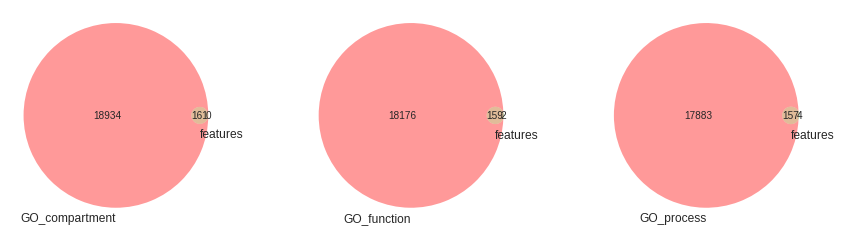

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

venn.venn2(subsets=(set(C_GO_prots), set(features)), set_labels=("GO_compartment", "features"), ax=ax[0])
venn.venn2(subsets=(set(F_GO_prots), set(features)), set_labels=("GO_function", "features"), ax = ax[1])
venn.venn2(subsets=(set(P_GO_prots), set(features)), set_labels=("GO_process", "features"), ax = ax[2])

In [10]:
def return_missing_ontology(go_prots):
    missing_ontology = []
    for p in features:
        if p not in go_prots:
            missing_ontology.append(p)
    return missing_ontology

In [11]:
missing_ontology_C = return_missing_ontology(C_GO_prots)
uniprot_description.loc[missing_ontology_C,:]

Empty DataFrame
Columns: [description]
Index: []

In [12]:
missing_ontology_F = return_missing_ontology(F_GO_prots)
uniprot_description.loc[missing_ontology_F,:]

description
uniprot_id                                   
P43121       Cell surface glycoprotein MUC18 
Q3KQU3      MAP7 domain-containing protein 1

In [13]:
missing_ontology_P = return_missing_ontology(P_GO_prots)
uniprot_description.loc[missing_ontology_P,:]

description
uniprot_id                                                   
Q07065                     Cytoskeleton-associated protein 4 
Q53EP0      Fibronectin type III domain-containing protein...
Q8IWE2                                        Protein NOXP20 
Q96HQ2                      CDKN2AIP N-terminal-like protein

---

# Global importance

In [155]:
shap_values_lr_test = explainer_cpu_lr.shap_values(x_lr_correct)
shap_values_lr_train = explainer_cpu_lr.shap_values(X_train)

(15, 102, 161)

In [154]:
shap_values_transposed = shap_lr_test.transpose(0, 1, 2)

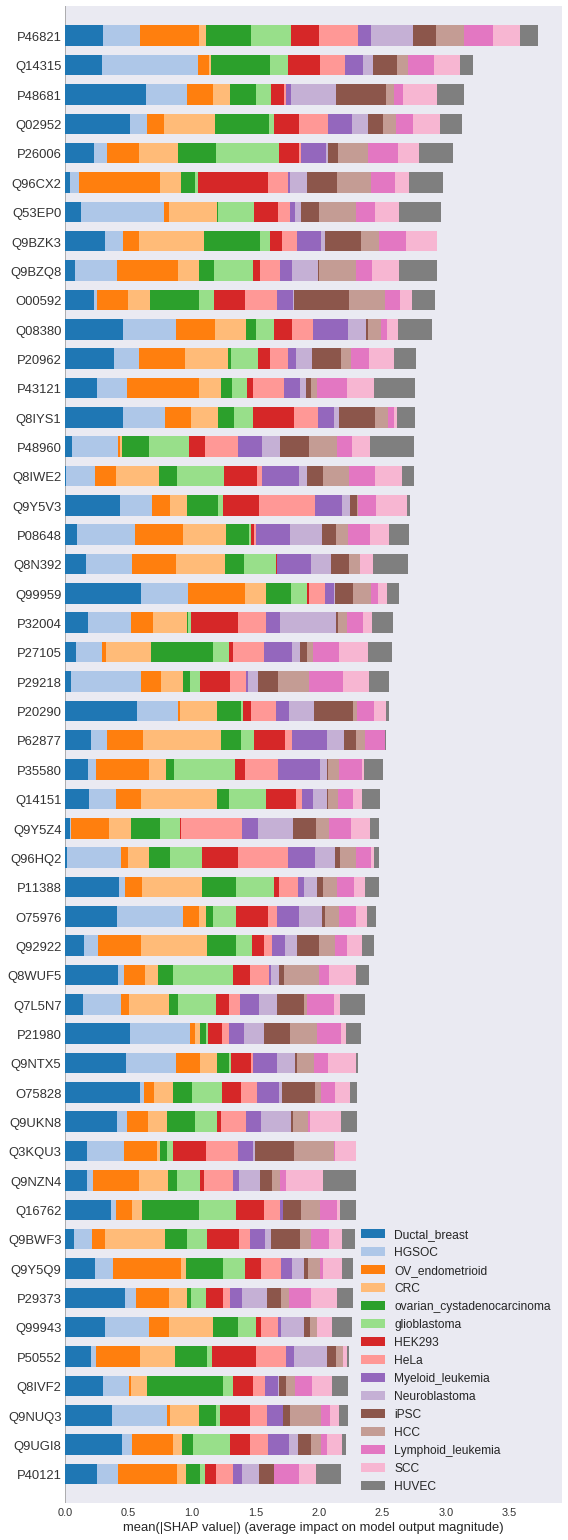

In [181]:
shap.summary_plot(shap_values_lr_test, x_lr_correct, plot_type="bar", class_names= target_encoder.inverse_transform(lr_smote.classes_), feature_names = feature_names,
            color=plt.get_cmap("tab20"), max_display = 50)

P46821 is most important: Microtubule-associated protein 1B

Get rank plots for the SHAPS per class

In [34]:
def rank_plot_shap(shaps, y, color=False, top_n=False):
    fig, ax = plt.subplots(3,5, figsize=(35,15))

    y_axis = 0
    x_axis = 0

    if color:
        pos_shaps_ids, _ = get_stats_shap_threshold(shaps,y,top_n=top_n, return_by_list=True)

    for i in range(15):
        
        # Get the table of shap values for class i
        shaps_df = pd.DataFrame(shaps[i], columns=features)

        # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == i,:].mean(), columns = ["mean"])
        stat_shaps_df["std"] = shaps_df.loc[y == i,:].std()

        stat_shaps_df = stat_shaps_df["mean"].sort_values().reset_index()
        stat_shaps_df["x_axis"] = list(range(161))

        ax[x_axis][y_axis].set_title(target_encoder.inverse_transform([i]))
        sns.scatterplot(data=stat_shaps_df, x="x_axis", y="mean", ax=ax[x_axis][y_axis], hue=["not selected"]*(161-len(pos_shaps_ids[i])) + ["selected"]*len(pos_shaps_ids[i]))

        # Create cumulative distribution plot of the mean shap value of the proteins to see whether a few proteins have large shap value means for each class
        # This enables to inituitively select top % features based on their shap values
        # ax[x_axis][y_axis].set_title(target_encoder.inverse_transform([i]))
        # sns.ecdfplot(abs(stat_shaps_df['mean']), ax=ax[x_axis][y_axis])

        y_axis += 1
        if y_axis == 5:
            y_axis=0
            x_axis+=1

def get_stats_shap(shaps, y):
    '''Returns pos_shaps (counts), class_proteins (dict)'''
    pos_shaps_lr = []
    class_proteins_lr = {}
    for i in range(15):
        
        class_name = target_encoder.inverse_transform([i])[0]
        # Get the table of shap values for class i
        shaps_df = pd.DataFrame(shaps[i], columns=features)

        # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == i,:].mean(), columns = ["mean"])
        stat_shaps_df["std"] = shaps_df.loc[y == i,:].std()

        class_proteins_lr[class_name] = stat_shaps_df.index[stat_shaps_df["mean"] > 0].tolist()
        pos_shaps_lr.append(len(class_proteins_lr[class_name]))

        print(class_name , len(class_proteins_lr[class_name]))
    return pos_shaps_lr, class_proteins_lr

def get_stats_shap_threshold(shaps, y, std_lower=1.96, std_higher=1.96, top_n=False, return_by_list=True):
    class_proteins_svc_pos = {}
    class_proteins_svc_neg = {}
    class_top_n = {}

    prot_pos = []
    prot_neg = []
    top_n_list = []

    for i in range(15):
        
        class_name = target_encoder.inverse_transform([i])[0]

        # Get the table of shap values for class i
        shaps_df = pd.DataFrame(shaps[i], columns=features)

        # Create dataframe with mean and std of the shap values for the test_samples corresponding to that class 
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == i,:].mean(), columns = ["mean"])
        stat_shaps_df["std"] = shaps_df.loc[y == i,:].std()

        stat_shaps_df = stat_shaps_df["mean"].sort_values().reset_index()
        stat_shaps_df["x_axis"] = list(range(161))
        
        if top_n:
            class_top_n[class_name] = list(stat_shaps_df["index"][-top_n:])
            top_n_list.append(list(stat_shaps_df["index"][-top_n:]))
        
        # Get significantly positive shap values (most important features)
        mean_of_means, std_of_means = stat_shaps_df["mean"].mean(), stat_shaps_df["mean"].std()
        threshold_pos = mean_of_means + std_higher*std_of_means
        sign_proteins_pos = stat_shaps_df["index"][stat_shaps_df["mean"] > threshold_pos].tolist()
        class_proteins_svc_pos[class_name] = sign_proteins_pos

        threshold_neg = mean_of_means - std_lower*std_of_means
        sign_proteins_neg = stat_shaps_df["index"][stat_shaps_df["mean"] < threshold_neg].tolist()
        class_proteins_svc_neg[class_name] = sign_proteins_neg

        prot_pos.append(sign_proteins_pos)
        prot_neg.append(sign_proteins_neg)

    if top_n:
        if return_by_list:
            return top_n_list, "_"
        return class_top_n, "_"
    
    if return_by_list:
        return prot_pos, prot_neg
    return class_proteins_svc_pos, class_proteins_svc_neg

def get_df_shap(shaps, label, thresh=False, std_lower=1.96, std_higher=1.96):
    shaps_df = pd.DataFrame(shaps[label], column=features)
    stat_shaps_df = pd.DataFrame(shaps_df.loc[y_train_df == label,:].mean(), columns = ["mean"])

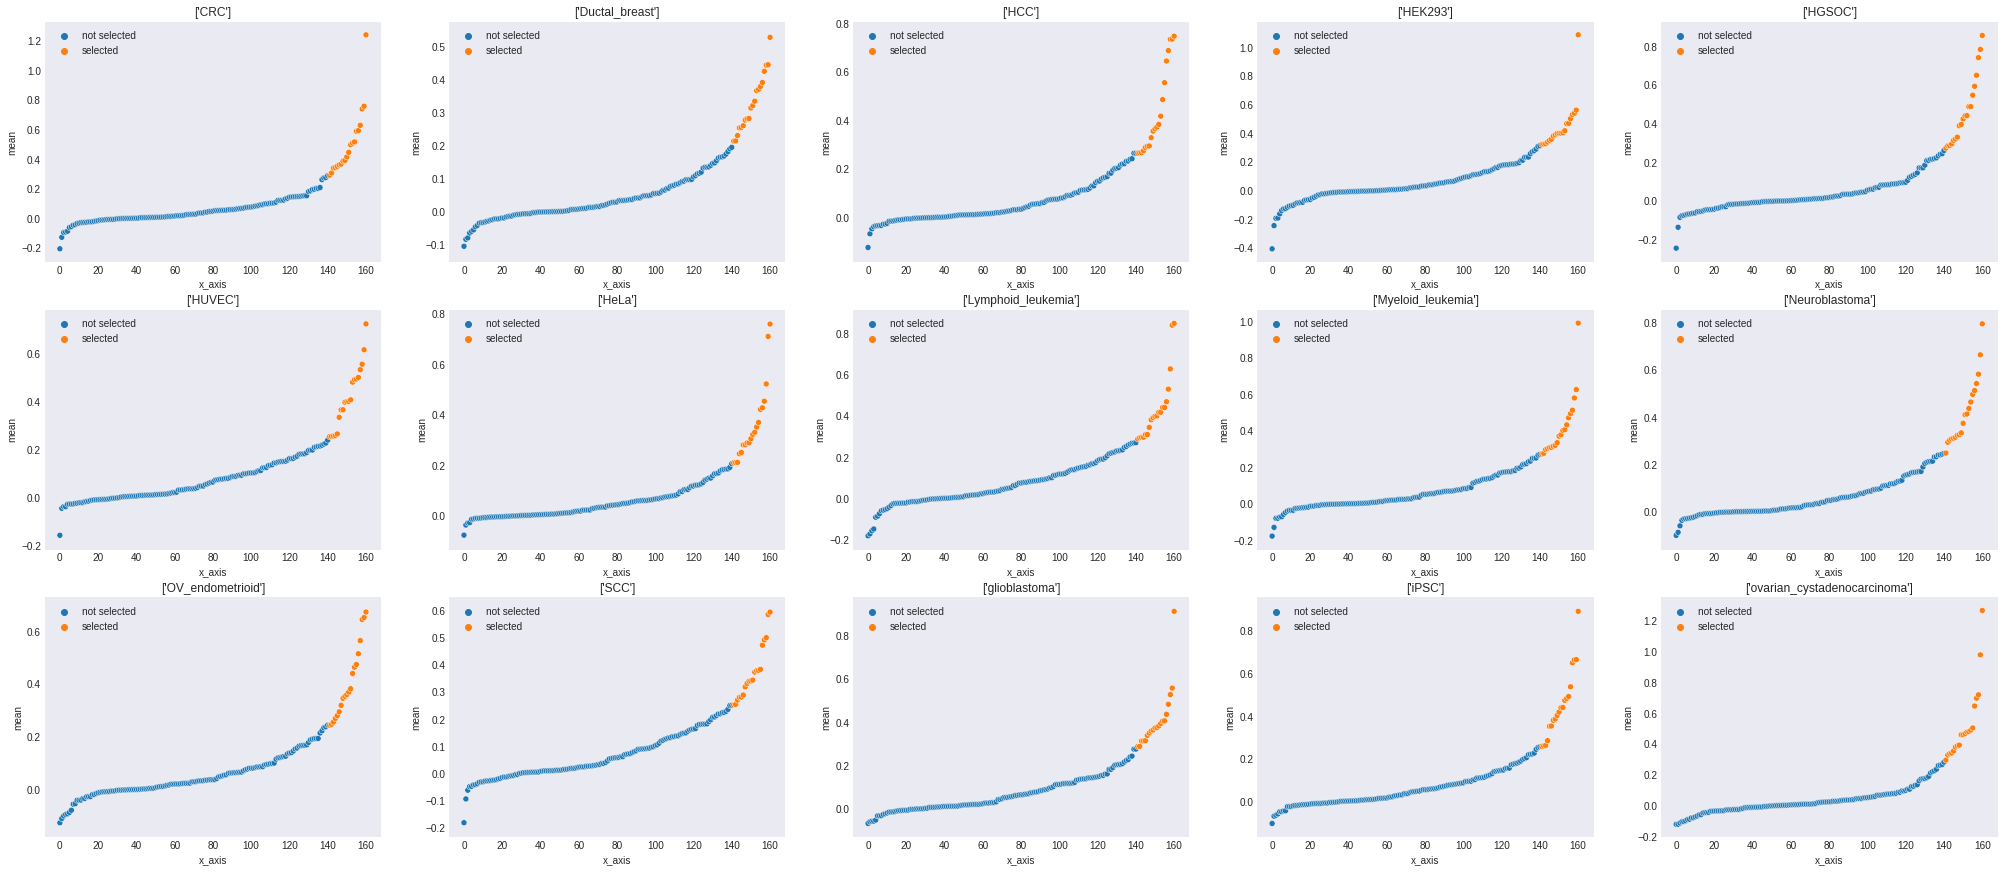

In [182]:
rank_plot_shap(shap_lr_test, y_lr_correct, color=True, top_n = 20)

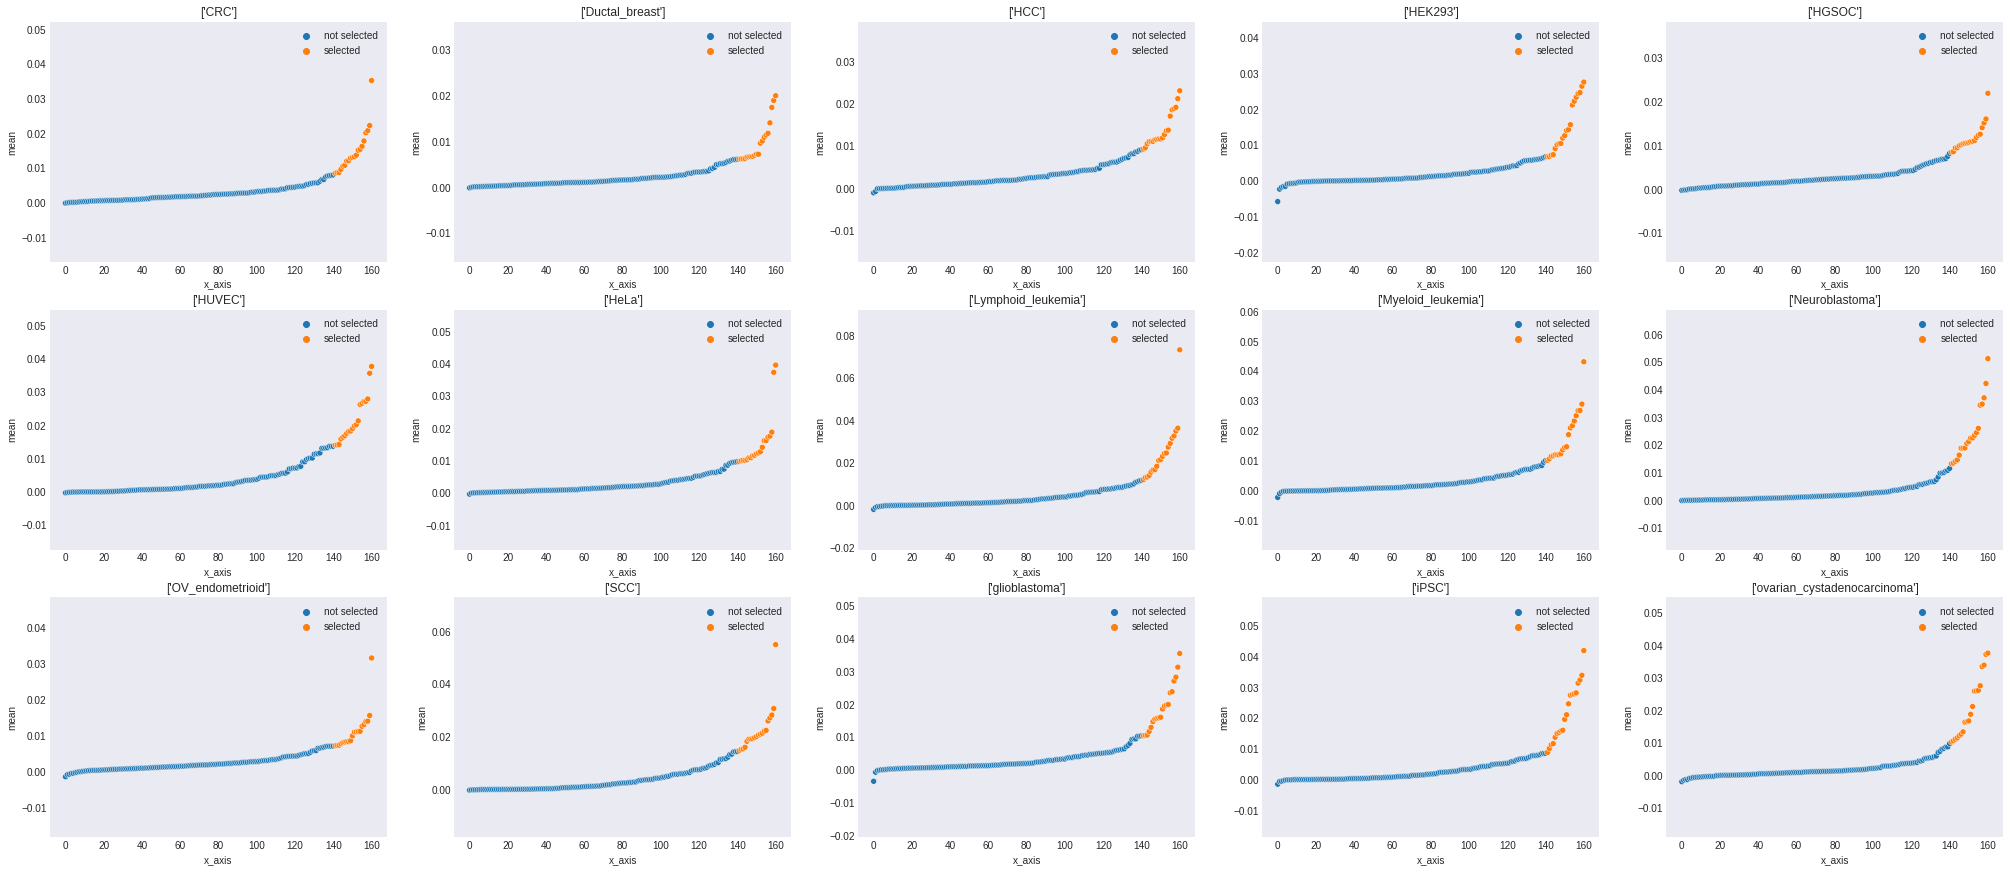

In [183]:
rank_plot_shap(shap_rf_test, y_rf_correct, color=True, top_n=20)

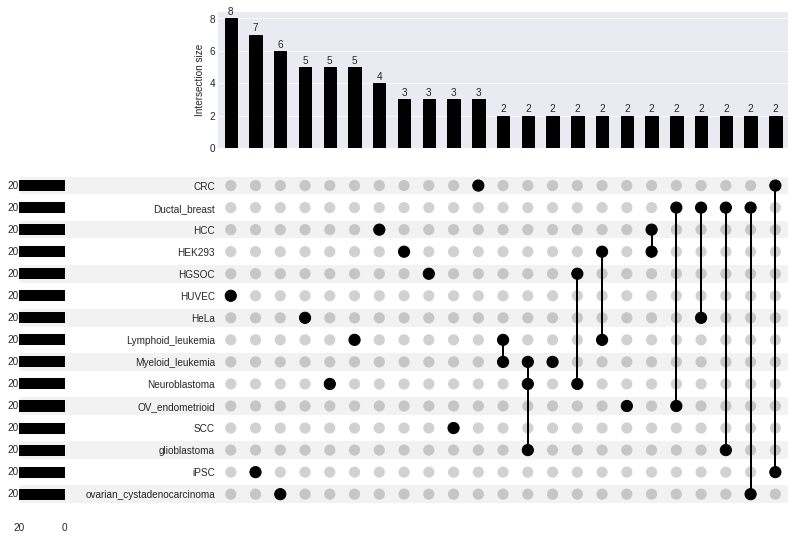

In [186]:
class_proteins_lr, _ = get_stats_shap_threshold(shap_values_lr_test, y_lr_correct, top_n=20, return_by_list=False)
upset_cp_pos = uplt.from_contents(class_proteins_lr)
uplt.UpSet(upset_cp_pos, show_counts=True, sort_by="cardinality", min_subset_size=2)

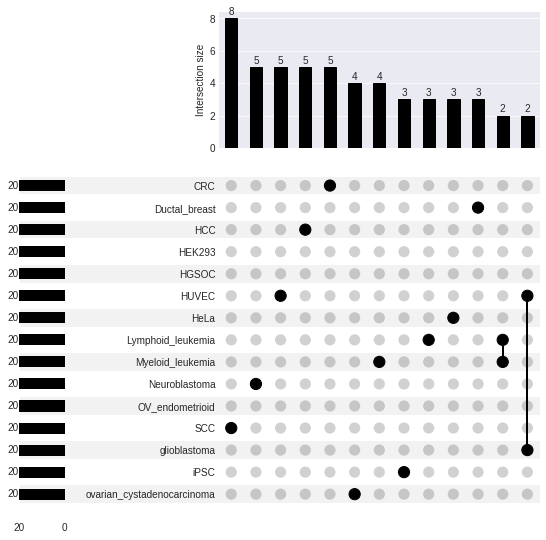

In [187]:
class_proteins_rf, _ = get_stats_shap_threshold(shap_values_rf_test, y_rf_correct, top_n=20, return_by_list=False)
upset_cp_pos = uplt.from_contents(class_proteins_rf)
uplt.UpSet(upset_cp_pos, show_counts=True, sort_by="cardinality", min_subset_size=2)

---

See the overlap of most important proteins for classification between classifiers

In [188]:
overlap_df = {"Group": [], "uniprot_id": [], "description": []}

for n in class_proteins_lr.keys():

    for prot in set(class_proteins_lr[n]).intersection(set(class_proteins_rf[n])):
        overlap_df["Group"].append(n)
        overlap_df["uniprot_id"].append(prot)
        overlap_df["description"].append(uniprot_description.loc[prot][0])

In [189]:
pd.DataFrame(overlap_df)

Group uniprot_id                        description
0                           CRC     P08670                           Vimentin
1                           CRC     P16144                   Integrin beta-4 
2                           CRC     P62877  E3 ubiquitin-protein ligase RBX1 
3                           CRC     P62805                         Histone H4
4                           CRC     P27105                          Stomatin 
..                          ...        ...                                ...
111  ovarian_cystadenocarcinoma     Q02952        A-kinase anchor protein 12 
112  ovarian_cystadenocarcinoma     Q9UJC3            Protein Hook homolog 1 
113  ovarian_cystadenocarcinoma     Q14126                      Desmoglein-2 
114  ovarian_cystadenocarcinoma     Q6NZI2     Caveolae-associated protein 1 
115  ovarian_cystadenocarcinoma     Q8IVF2                     Protein AHNAK2

[116 rows x 3 columns]

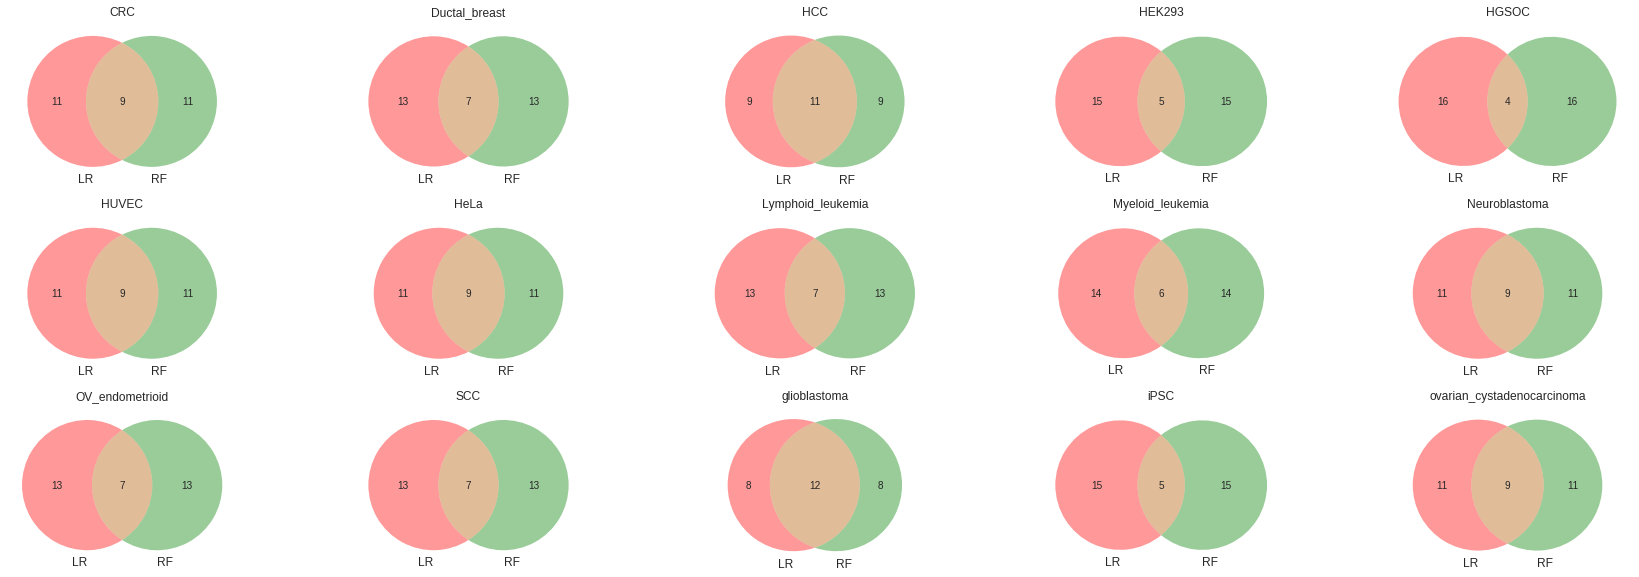

In [190]:
fig, ((ax1,ax2,ax3,ax4,ax5), (ax6,ax7,ax8,ax9,ax10), (ax11,ax12,ax13,ax14,ax15)) = plt.subplots(3,5,figsize=(30,10))

axes = [ax1,ax2,ax3,ax4,ax5, ax6,ax7,ax8,ax9,ax10, ax11,ax12,ax13,ax14,ax15]
for i in range(15):
    class_name = target_encoder.inverse_transform([i])[0]

    lr_features = set(class_proteins_lr[class_name])
    #svc_features = set(class_proteins_svc_pos[class_name])
    rf_features = set(class_proteins_rf[class_name])

    axes[i].set_title(class_name)
    venn.venn2(subsets = (lr_features, rf_features), set_labels = ('LR', 'RF'), ax=axes[i])

---

In [191]:
abundance_df = pd.DataFrame(index=features)
abundance_df_std = pd.DataFrame(index=features)

for i in range(15):

    abundance_df[target_encoder.inverse_transform([i])[0] + '_mean'] = pd.DataFrame(x_lr_correct, columns=features).loc[y_lr_correct == i,:].mean()
    abundance_df_std[target_encoder.inverse_transform([i])[0] + '_std'] = pd.DataFrame(x_lr_correct, columns=features).loc[y_lr_correct == i,:].std()
rank_df = abundance_df.rank(axis=1).rename(columns={x+"_mean":x+"_rank" for x in target_encoder.inverse_transform(range(15))})

In [192]:
def get_summary_df(label, shaps, y, top_n=False, ranked=False, thresholding=False, threshold_std=1.96, keep_only_enriched=False, hard_threshold=False):    
    
    shaps_df = pd.DataFrame(shaps[label], columns=features)

    if ranked:
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == label,:].mean(), columns = ["SHAP_mean"]).rank()
    else:
        stat_shaps_df = pd.DataFrame(shaps_df.loc[y == label,:].mean(), columns = ["SHAP_mean"])
    stat_shaps_df["Abundance_rank"] = rank_df[target_encoder.inverse_transform([label])[0]+"_rank"]
    stat_shaps_df["Abundance_mean"] = abundance_df.loc[:,target_encoder.inverse_transform([label])[0]+'_mean']
    stat_shaps_df["Abundance_std"] = abundance_df_std.loc[:,target_encoder.inverse_transform([label])[0]+'_std']
    stat_shaps_df["description"] = uniprot_description.loc[stat_shaps_df.index,"description"]
    
    stat_shaps_df = stat_shaps_df.sort_values("SHAP_mean", ascending=False)[:top_n]
    if top_n:
        stat_shaps_df = stat_shaps_df[:top_n]
        
        
    if hard_threshold:
        stat_shaps_df = stat_shaps_df.loc[stat_shaps_df.index[stat_shaps_df["SHAP_mean"] > hard_threshold],:]

    if thresholding:
        mean_of_means, std_of_means = stat_shaps_df["SHAP_mean"].mean(), stat_shaps_df["SHAP_mean"].std()
        threshold_pos = mean_of_means + threshold_std*std_of_means

        stat_shaps_df = stat_shaps_df.loc[stat_shaps_df.index[stat_shaps_df["SHAP_mean"] > threshold_pos],:]

    if keep_only_enriched:
        stat_shaps_df = stat_shaps_df.loc[stat_shaps_df.index[stat_shaps_df["Abundance_rank"] >= 8],:]

    return stat_shaps_df

In [193]:
get_summary_df(i, shap_lr_test, y_lr_correct, top_n=161, ranked=True)

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std  \
Q8IVF2      161.0            15.0        0.896314       0.146633   
Q14126      160.0            15.0        0.950318       0.070261   
P11766      159.0             1.0        0.301519       0.146505   
P12956      158.0             1.0        0.111670       0.012680   
Q9UJC3      157.0            15.0        0.882936       0.039498   
...           ...             ...             ...            ...   
Q9Y5B9        5.0            13.0        0.869453       0.089194   
P29350        4.0            13.0        0.535925       0.091648   
Q08211        3.0            13.0        0.786308       0.023799   
Q14151        2.0            15.0        0.787717       0.003301   
Q9NR30        1.0            11.0        0.856638       0.156633   

                                              description  
Q8IVF2                                     Protein AHNAK2  
Q14126                                      Desmoglein-2   
P11766                     Alcohol dehydrogenase class-3   
P12956        X-ray repair cross-complementing protein 6   
Q9UJC3                            Protein Hook homolog 1   
...                                                   ...  
Q9Y5B9                        FACT complex subunit SPT16   
P29350  Tyrosine-protein phosphatase non-receptor type 6   
Q08211                      ATP-dependent RNA helicase A   
Q14151                     Scaffold attachment factor B2   
Q9NR30                          Nucleolar RNA helicase 2   

[161 rows x 5 columns]

In [ ]:
get_summary_df(0, shap_lr_test, y_lr_correct, top_n=161)

In [310]:
all=pd.DataFrame()
for i in range(15):
    summaries_lr = get_summary_df(i, shap_lr_test, y_lr_correct, top_n=161).sort_index()
    summaries_rf = get_summary_df(i, shap_rf_test, y_rf_correct, top_n=161).sort_index()
    summaries_lr["RF_SHAP_mean"] = summaries_rf.SHAP_mean
    summaries_lr["SHAP_mean RF_SHAP_mean".split()]=summaries_lr["SHAP_mean RF_SHAP_mean".split()].rank()
    thresh_i = summaries_lr.loc[(summaries_lr.SHAP_mean >141) & (summaries_lr.RF_SHAP_mean>141)].index
    subset = summaries_lr.loc[thresh_i]
    subset["Group"] = target_encoder.inverse_transform([i])[0]

    all = pd.concat([all, subset])

In [313]:
all.to_csv("Most_important_features_common.csv")

In [307]:
all.Group.value_counts()

HGSOC                         36
iPSC                          35
HEK293                        35
Myeloid_leukemia              34
Lymphoid_leukemia             33
SCC                           33
Ductal_breast                 33
OV_endometrioid               33
CRC                           31
ovarian_cystadenocarcinoma    31
HUVEC                         31
Neuroblastoma                 31
HeLa                          31
HCC                           29
glioblastoma                  28
Name: Group, dtype: int64

In [308]:
all.head()

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std  \
O43707      105.0             4.0        0.407944       0.184283   
O60264       14.0             5.0        0.516356       0.067817   
P08670      147.0             2.0        0.301836       0.063835   
P11388      158.0             2.0        0.238883       0.125404   
P16144      154.0            14.0        0.697671       0.229758   

                                              description  RF_SHAP_mean Group  
O43707                                   Alpha-actinin-4          147.0   CRC  
O60264  SWI/SNF-related matrix-associated actin-depend...         157.0   CRC  
P08670                                           Vimentin         159.0   CRC  
P11388                         DNA topoisomerase 2-alpha          158.0   CRC  
P16144                                   Integrin beta-4          153.0   CRC

In [ ]:
shap.plots.scatter()

In [312]:
for x in all[all.Group == "CRC"].index:

SHAP_mean  Abundance_rank  Abundance_mean  Abundance_std  \
P08670      147.0             2.0        0.301836       0.063835   
P11388      158.0             2.0        0.238883       0.125404   
P16144      154.0            14.0        0.697671       0.229758   
P27105      153.0             2.0        0.212670       0.075805   
P62805      145.0             3.0        0.499021       0.175019   
P62877      161.0             2.0        0.201609       0.137689   
Q14151      159.0             3.0        0.195572       0.098635   
Q9BZK3      157.0             2.0        0.213820       0.068384   
Q9UDT6      160.0            15.0        0.699744       0.188371   

                                              description  RF_SHAP_mean Group  
P08670                                           Vimentin         159.0   CRC  
P11388                         DNA topoisomerase 2-alpha          158.0   CRC  
P16144                                   Integrin beta-4          153.0   CRC  
P27105                                          Stomatin          154.0   CRC  
P62805                                         Histone H4         160.0   CRC  
P62877                  E3 ubiquitin-protein ligase RBX1          156.0   CRC  
Q14151                     Scaffold attachment factor B2          155.0   CRC  
Q9BZK3  Putative nascent polypeptide-associated comple...         144.0   CRC  
Q9UDT6        CAP-Gly domain-containing linker protein 2          148.0   CRC

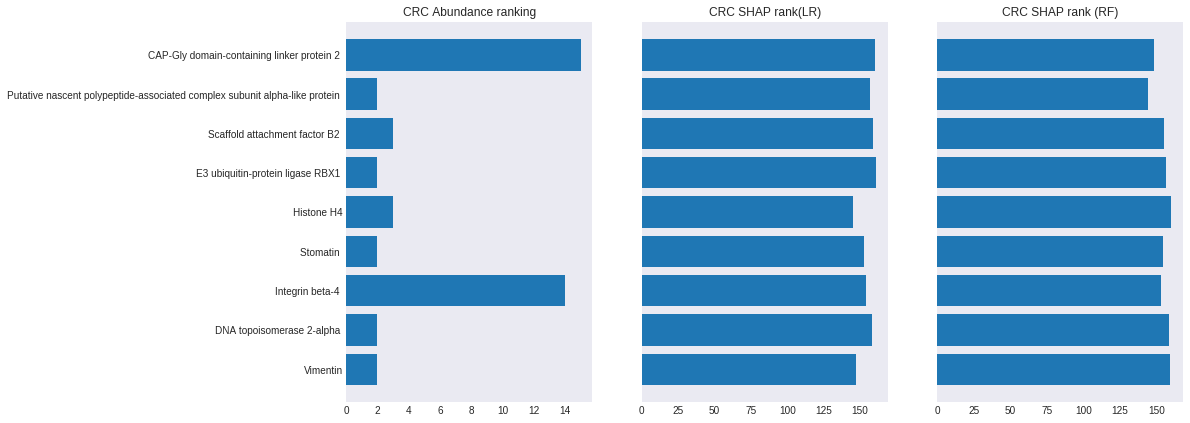

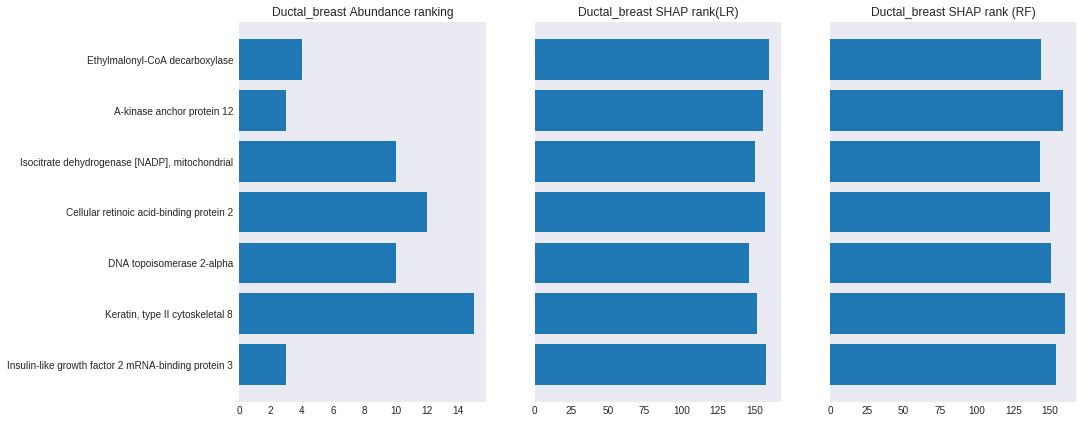

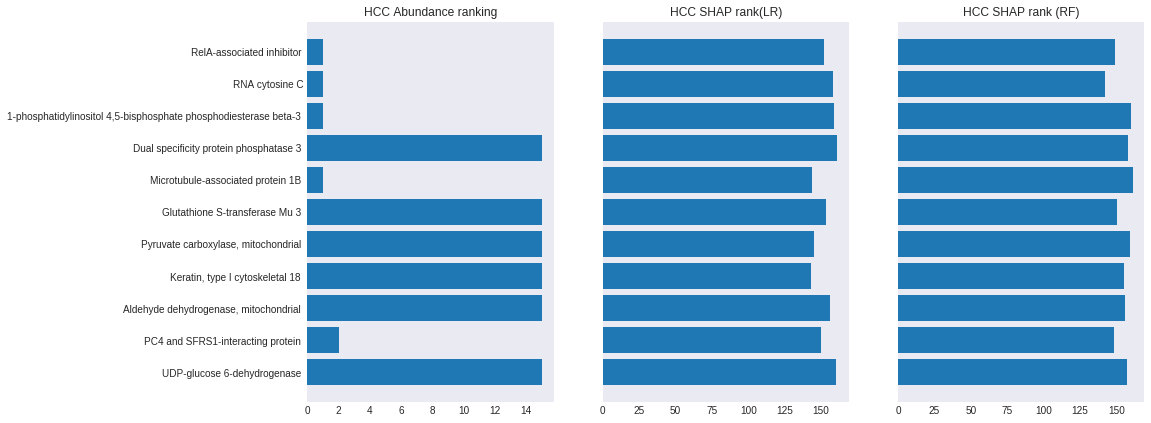

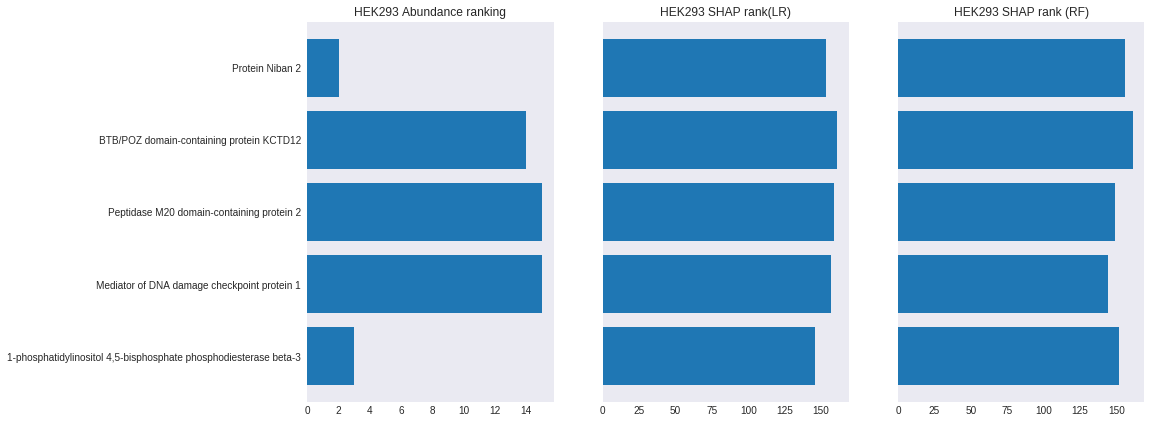

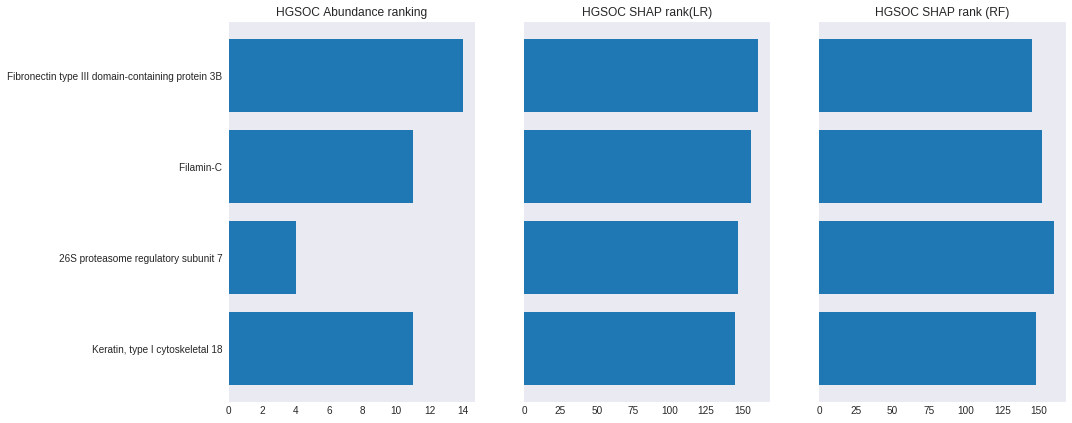

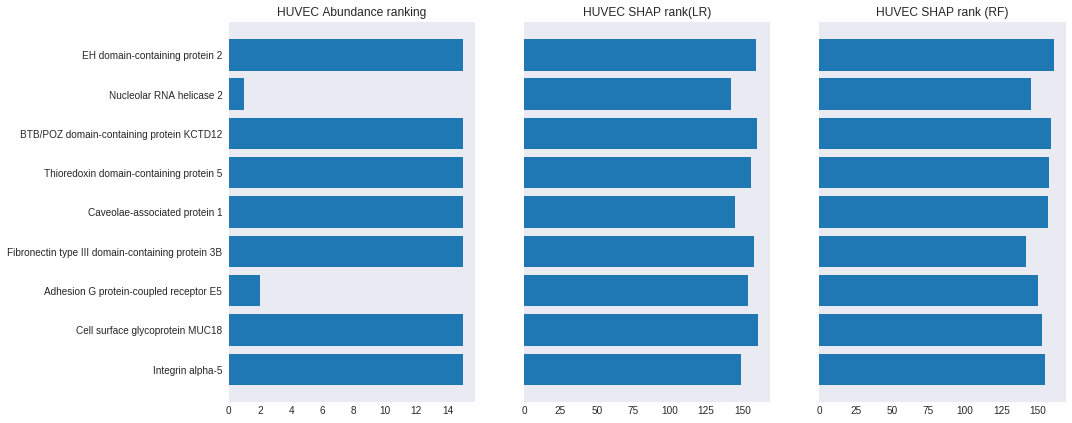

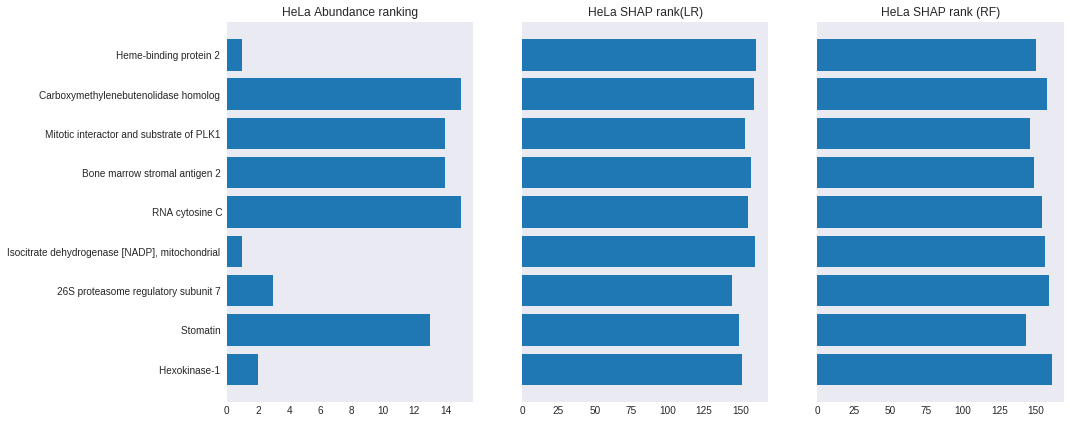

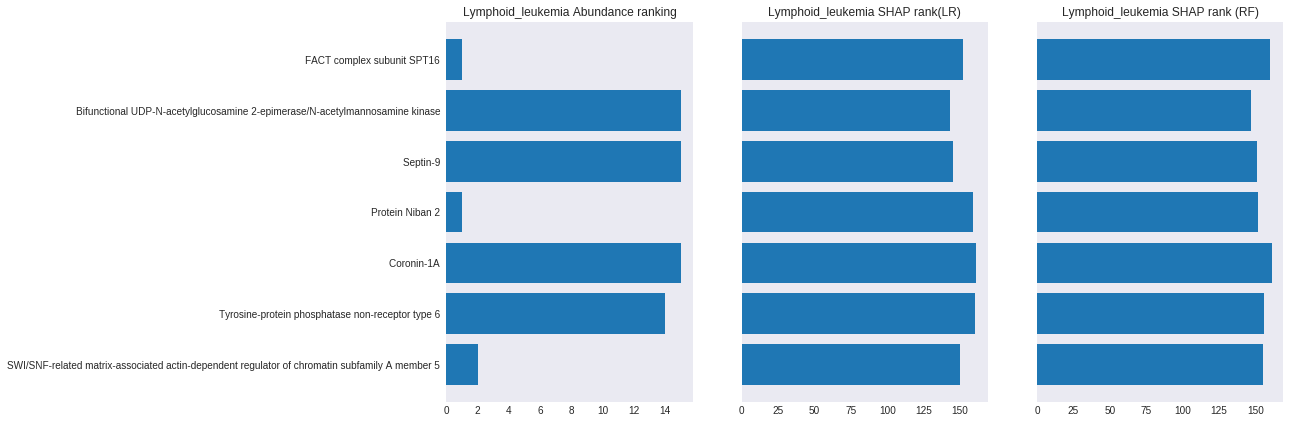

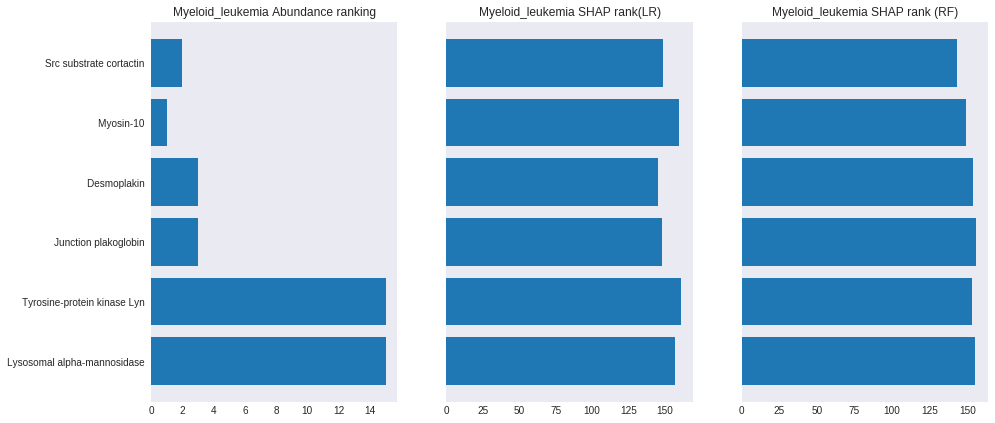

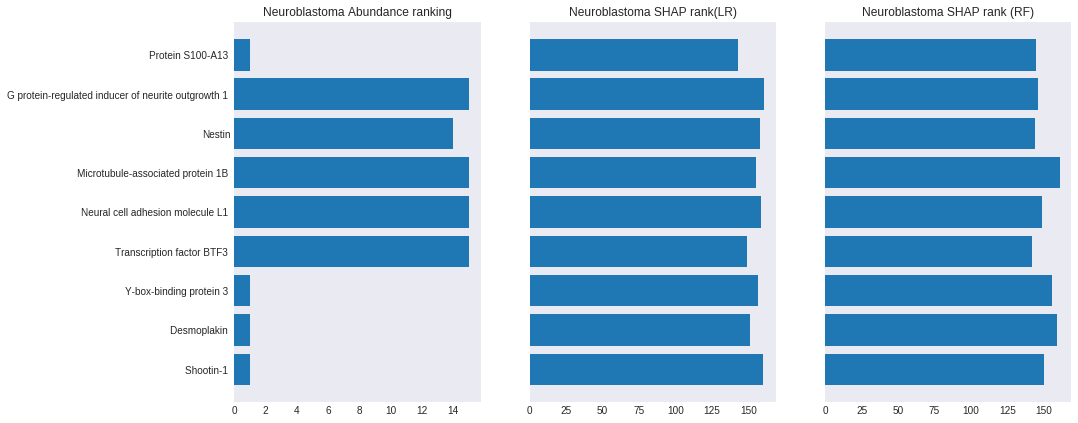

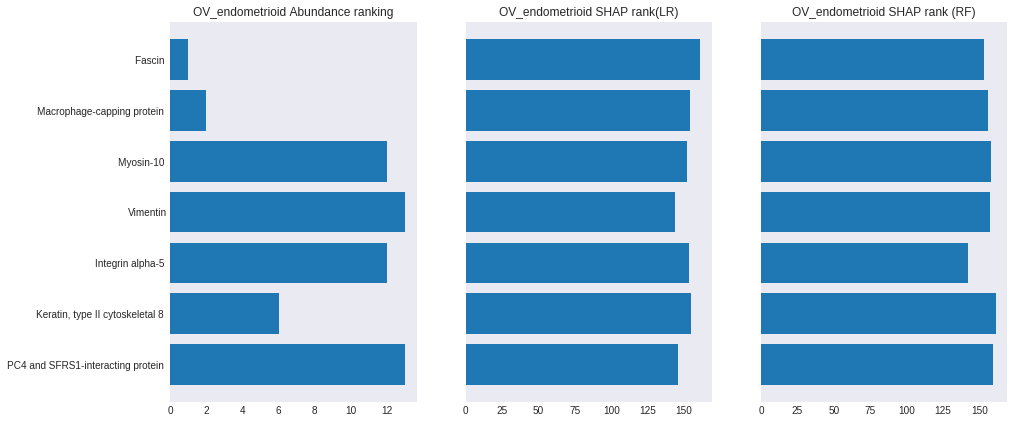

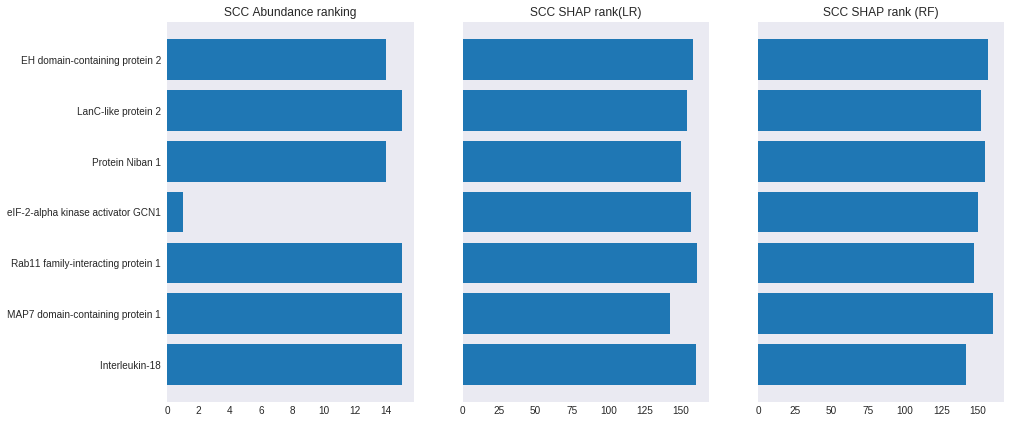

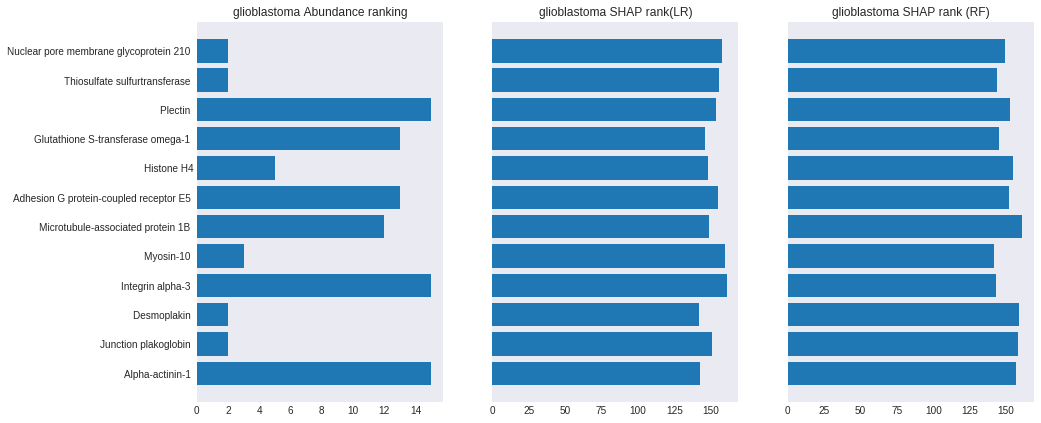

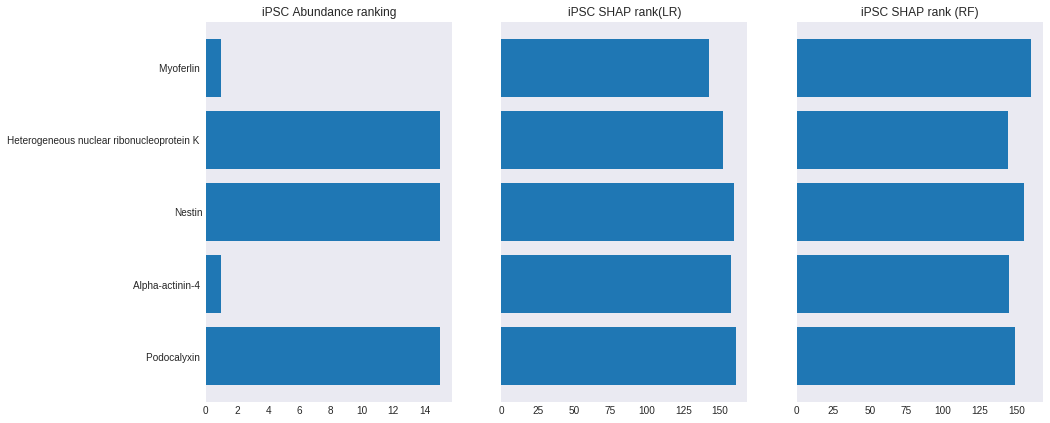

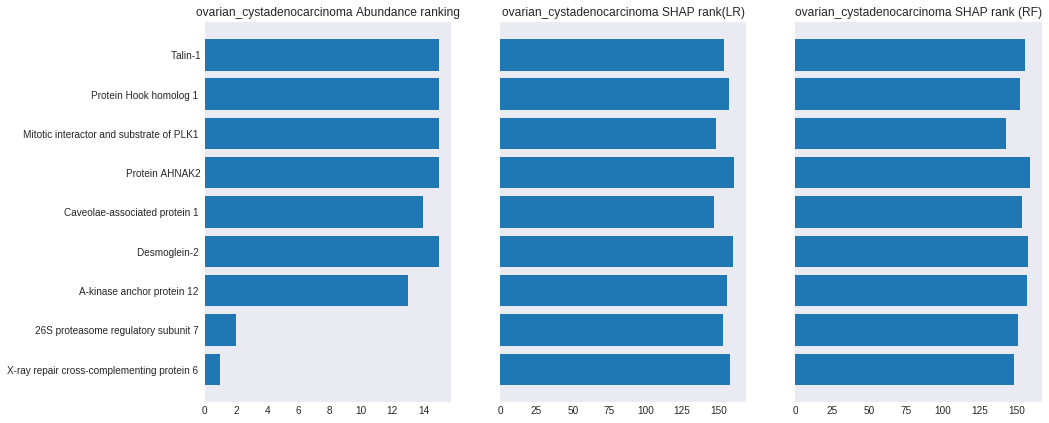

In [311]:
summaries_lr_thresh = []

for i in range(15):

    fig, ax = plt.subplots(1,3, figsize=(15,7), sharey=True)

    ax[0].barh(data = all[all.Group == target_encoder.inverse_transform([i])[0]], y = "description", width="Abundance_rank")
    ax[1].barh(data = all[all.Group == target_encoder.inverse_transform([i])[0]], y = "description", width="SHAP_mean")
    ax[2].barh(data = all[all.Group == target_encoder.inverse_transform([i])[0]], y = "description", width="RF_SHAP_mean")

    ax[1].set_ylabel(None)

    ax[0].set_title(target_encoder.inverse_transform([i])[0] + " Abundance ranking")
    ax[1].set_title(target_encoder.inverse_transform([i])[0] + " SHAP rank(LR)")
    ax[2].set_title(target_encoder.inverse_transform([i])[0] + " SHAP rank (RF)")

---

Split important features in "depleted" and "abundant" and sum the explanations and perform GO, string and reactome

In [210]:
combined_shaps = []
prots_per_class = {}

for i in range(15):
    lr_sum = get_summary_df(i, shap_lr_test, y_lr_correct, top_n=20)
    lr_sum["model"] = "LR"
    #svc_sum = get_summary_df(i, shap_svc_train, thresholding = True)
    #svc_sum["model"] = "SVC"
    rf_sum = get_summary_df(i, shap_rf_test, y_rf_correct, top_n=20)
    rf_sum["model"] = "RF"

    combined_shaps.append(pd.concat([lr_sum,rf_sum])) #svc_sum

    prots_per_class[target_encoder.inverse_transform([i])[0]] = combined_shaps[i].index.unique().tolist()

In [211]:
def calc_go(list_of_prots, go_type, missing_ontology):
    gos = []
    for prot in list_of_prots:
        if prot not in missing_ontology:
            gos += go_type[prot]
    go_df = {}

    renaming = {}
    for go in set(gos):
        go_df[go] = gos.count(go)

        if go in GO_description.index:
            renaming[go] = GO_description.loc[go].annotation_label

    return pd.Series(go_df).rename(index = renaming)

In [213]:
prots_per_class

{'CRC': ['P62877',
  'Q9UDT6',
  'Q14151',
  'P11388',
  'Q9BZK3',
  'Q9BWF3',
  'P52594',
  'P16144',
  'P27105',
  'P20962',
  'P80723',
  'Q8N392',
  'Q92922',
  'Q16352',
  'P08670',
  'Q9UHR4',
  'P62805',
  'P50552',
  'Q7L5N7',
  'P21266',
  'P31947',
  'O60264',
  'P35998',
  'P46013',
  'Q9NR30',
  'P46821',
  'O43707',
  'P19367',
  'Q96TA1',
  'Q14676',
  'Q15149'],
 'Ductal_breast': ['P48681',
  'Q9NTX5',
  'P21266',
  'O00425',
  'P29373',
  'Q02952',
  'O75976',
  'P30038',
  'O75828',
  'P05787',
  'Q8IYS1',
  'P48735',
  'P20962',
  'Q9UIQ6',
  'Q9Y5V3',
  'P11388',
  'Q15149',
  'P12814',
  'Q99959',
  'Q15555',
  'P31947',
  'P15924',
  'P04083',
  'P46821',
  'P08670',
  'P19367',
  'P26038',
  'O43707',
  'Q9Y446',
  'P35998',
  'P05783',
  'P35580',
  'Q14151'],
 'HCC': ['P51452',
  'O60701',
  'Q01970',
  'Q08J23',
  'Q9HC35',
  'P05091',
  'P29218',
  'Q15555',
  'P21266',
  'Q8WUF5',
  'O00592',
  'O75475',
  'Q9UIQ6',
  'P52594',
  'Q53EP0',
  'Q9BZQ8',
  'P114

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



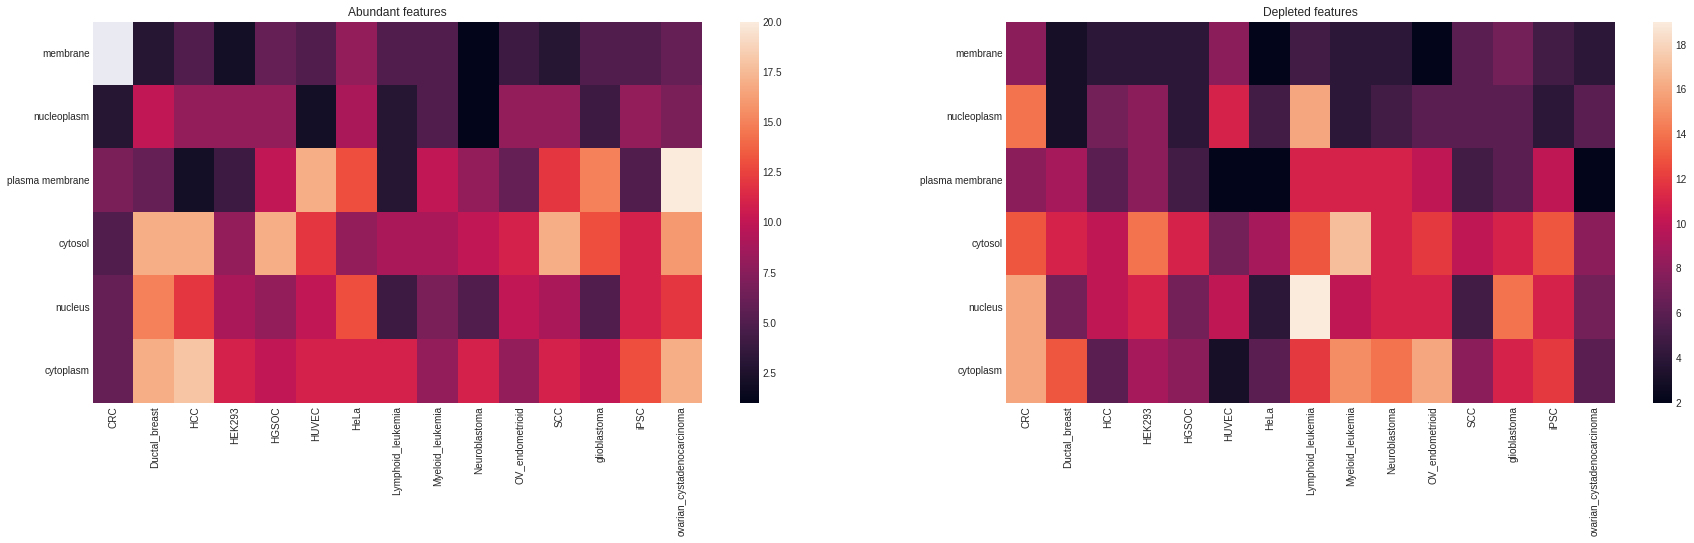

In [214]:
go_per_class_abundant = []
go_per_class_depleted = []

fig, ax = plt.subplots(1,2, figsize=(30,7))

for i, prots in prots_per_class.items():

    ind = target_encoder.transform([i])[0]
    abundant_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank > 7]
    depleted_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank <= 7]

    go_per_class_abundant.append(calc_go(abundant_important_features,  uniprot_go_compartment, missing_ontology_C).rename(i))
    go_per_class_depleted.append(calc_go(depleted_important_features,  uniprot_go_compartment, missing_ontology_C).rename(i))

ax[0].set_title("Abundant features")
ax[1].set_title("Depleted features")
sns.heatmap(pd.concat(go_per_class_abundant,axis=1).loc[["membrane", "nucleoplasm", "plasma membrane", "cytosol", "nucleus", "cytoplasm"]], ax = ax[0])
sns.heatmap(pd.concat(go_per_class_depleted,axis=1).loc[["membrane", "nucleoplasm", "plasma membrane", "cytosol", "nucleus", "cytoplasm"]], ax = ax[1])

12 28
23 17
25 15
19 21
24 16
25 15
27 13
12 28
16 24
20 20
20 20
24 16
19 21
21 19
30 10


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



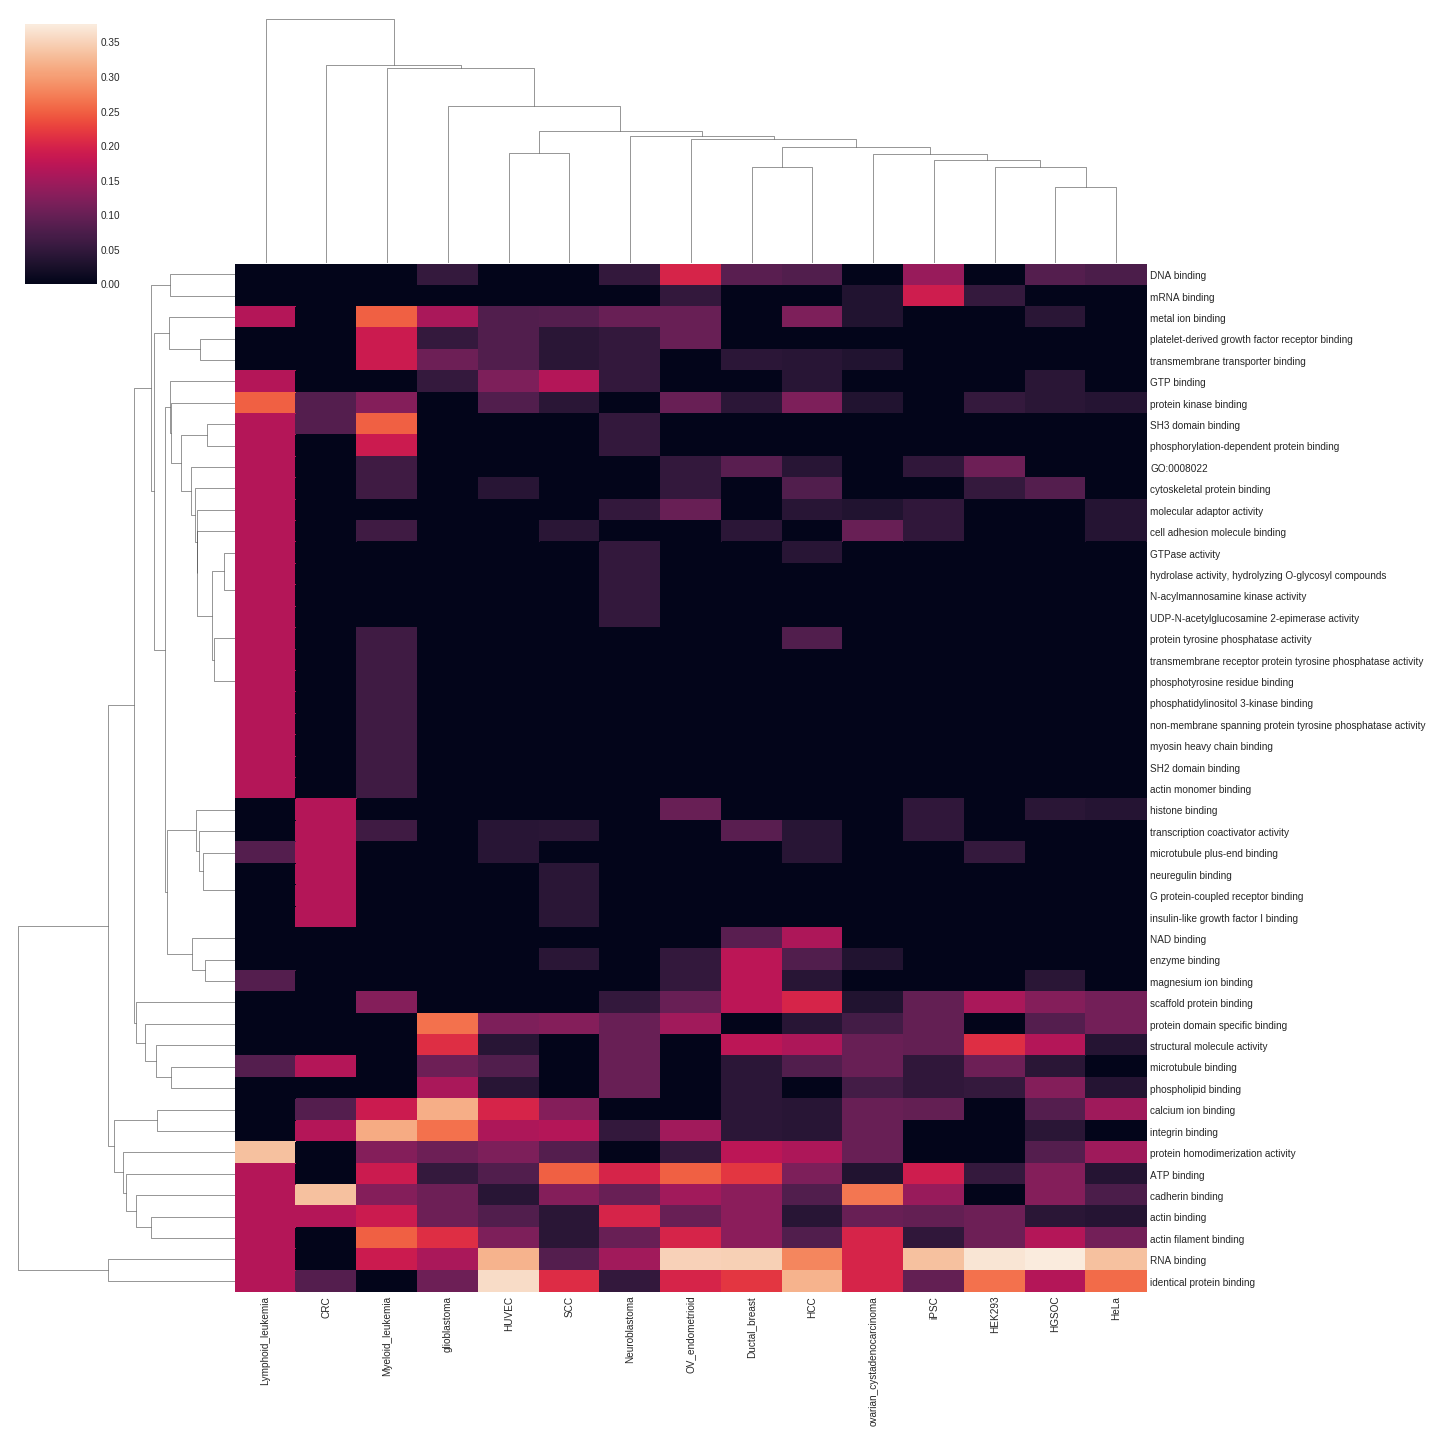

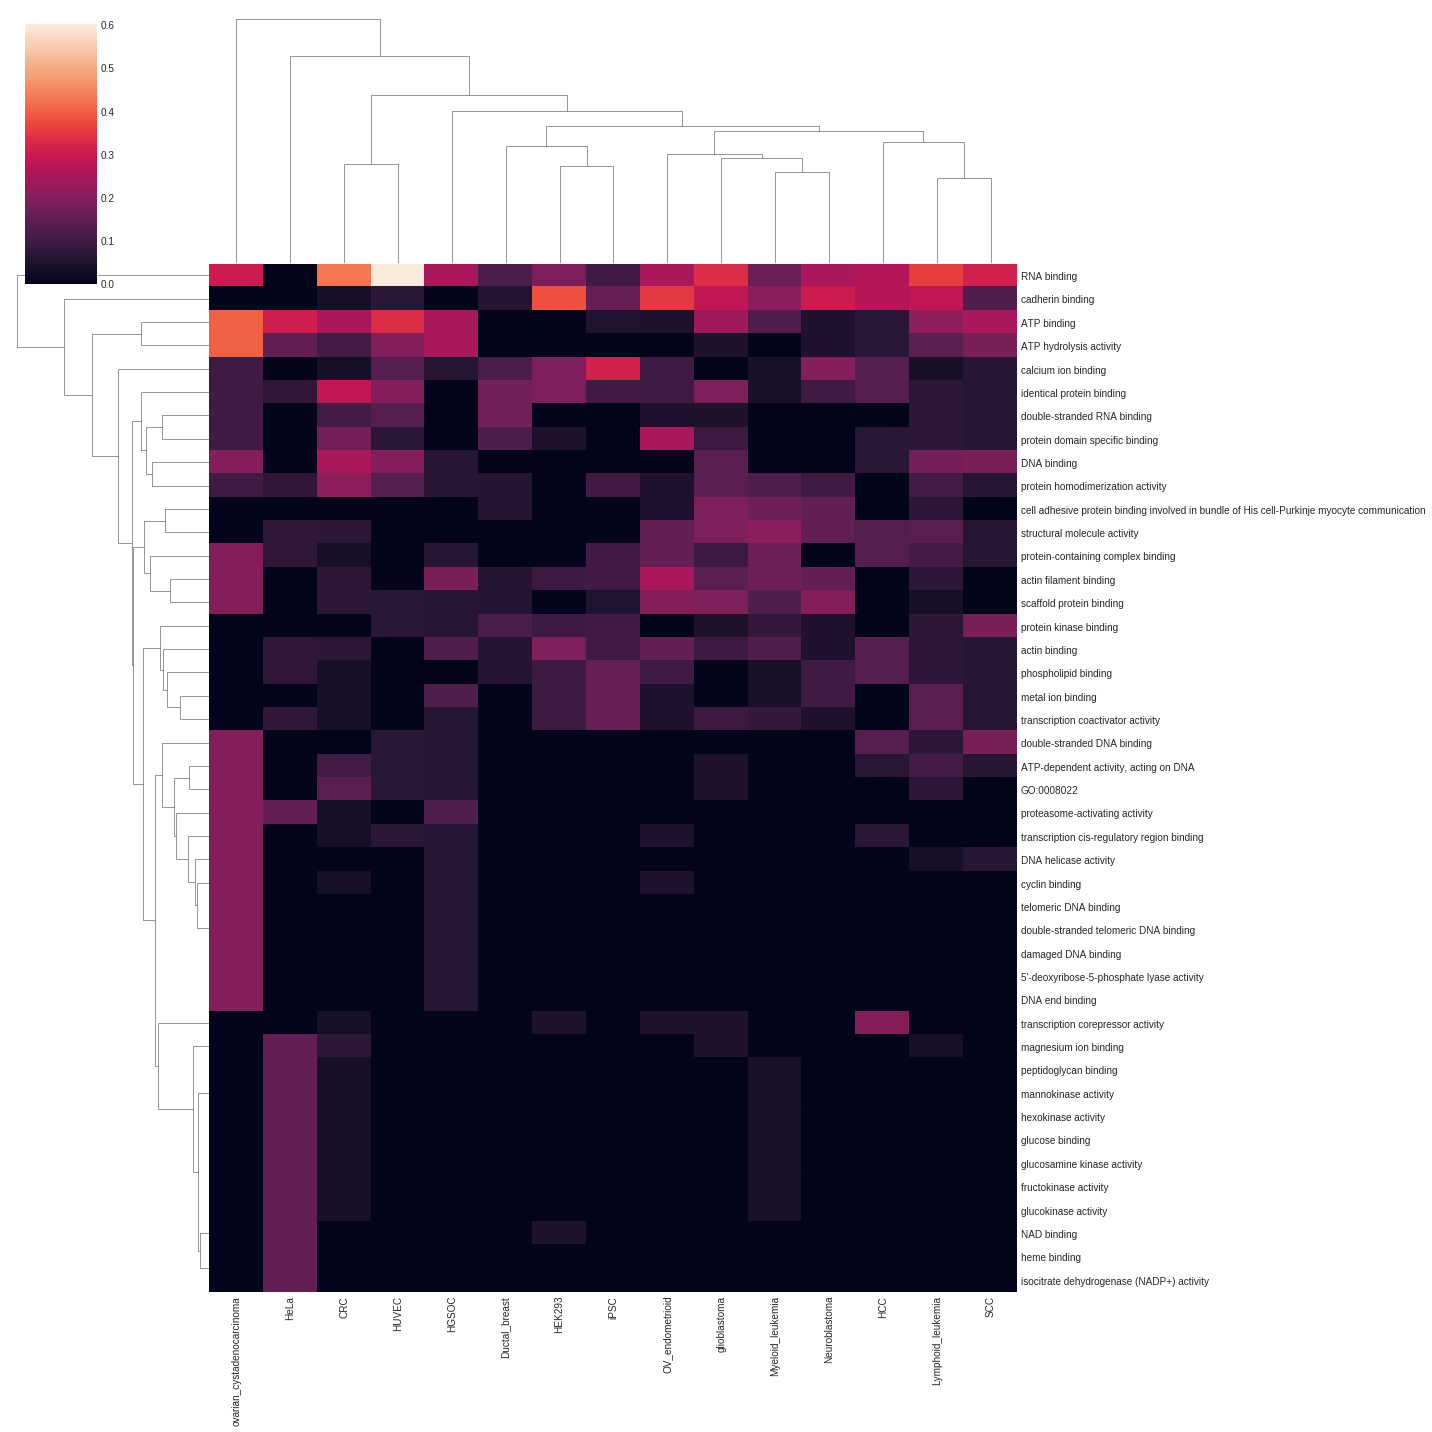

In [218]:
go_per_class_abundant = []
go_per_class_depleted = []

for i, prots in prots_per_class.items():

    ind = target_encoder.transform([i])[0]
    abundant_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank > 7]
    depleted_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank <= 7]

    go_per_class_abundant.append(calc_go(abundant_important_features, uniprot_go_function, missing_ontology_F).rename(i)/len(abundant_important_features))
    go_per_class_depleted.append(calc_go(depleted_important_features, uniprot_go_function, missing_ontology_F).rename(i)/len(depleted_important_features))

    print(len(abundant_important_features), len(depleted_important_features))

go_per_class_abundant = pd.concat(go_per_class_abundant,axis=1).fillna(0)
go_per_class_depleted = pd.concat(go_per_class_depleted,axis=1).fillna(0)

indices_abundant = go_per_class_abundant.index[(go_per_class_abundant<.5).any(axis=1) & (go_per_class_abundant>.15).any(axis=1)]
indices_depleted = go_per_class_depleted.index[(go_per_class_depleted<.5).any(axis=1) & (go_per_class_depleted>.15).any(axis=1)]

sns.clustermap(go_per_class_abundant.loc[indices_abundant], figsize=(20,20))
sns.clustermap(go_per_class_depleted.loc[indices_depleted], figsize=(20,20))

12 28
23 17
25 15
19 21
24 16
25 15
27 13
12 28
16 24
20 20
20 20
24 16
19 21
21 19
30 10


Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



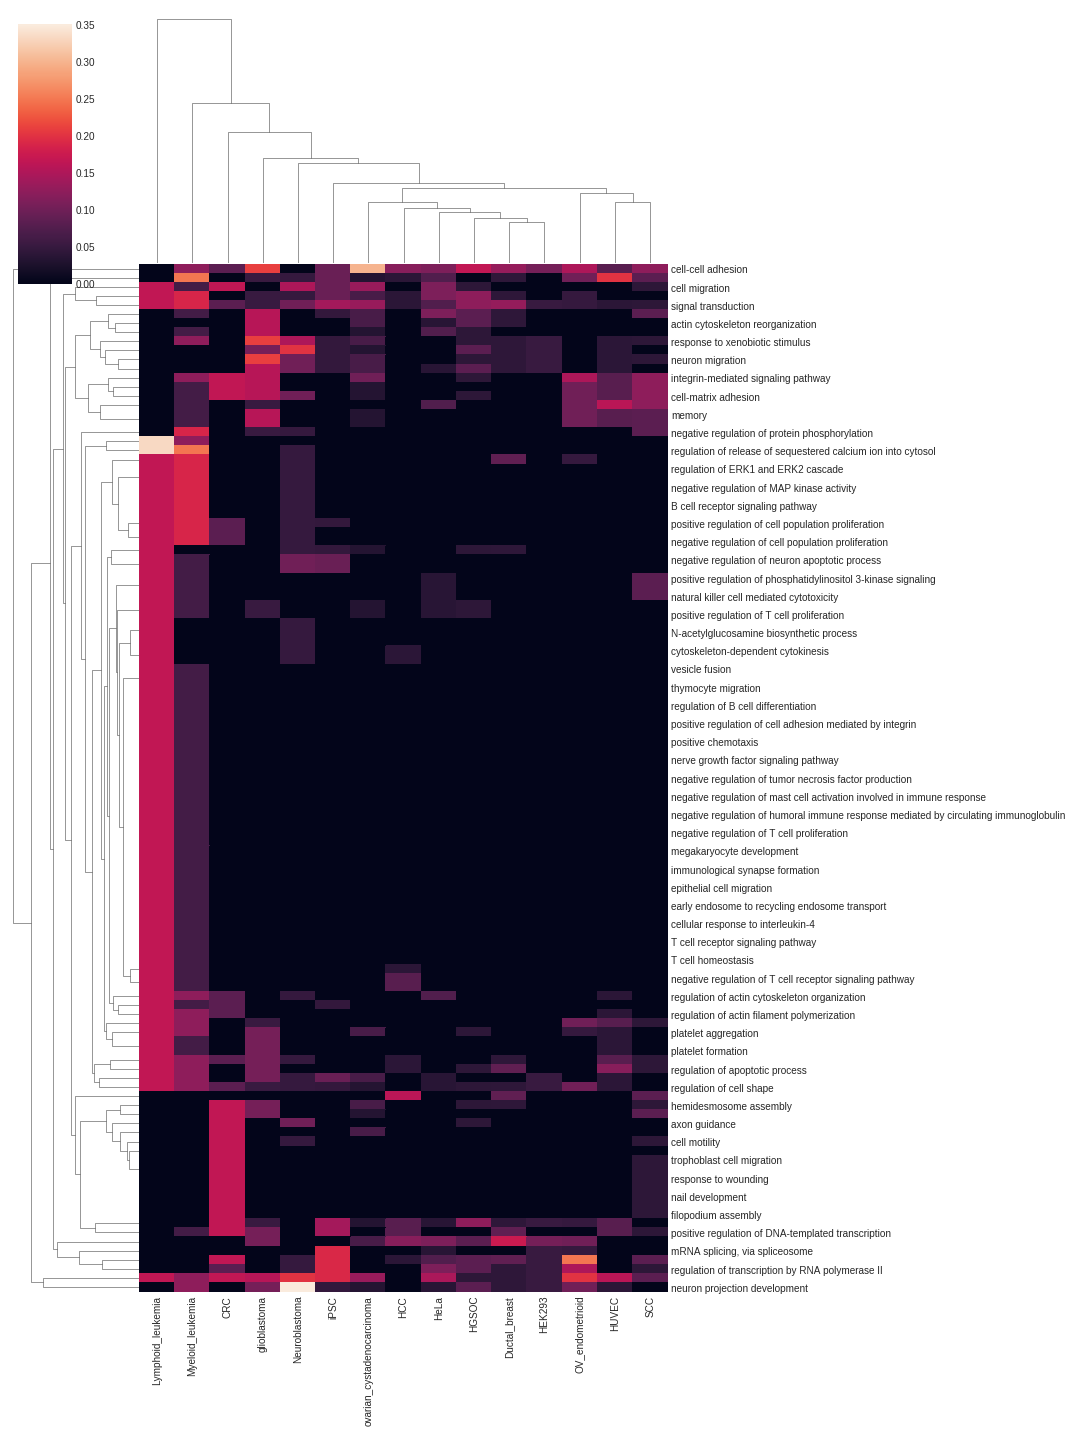

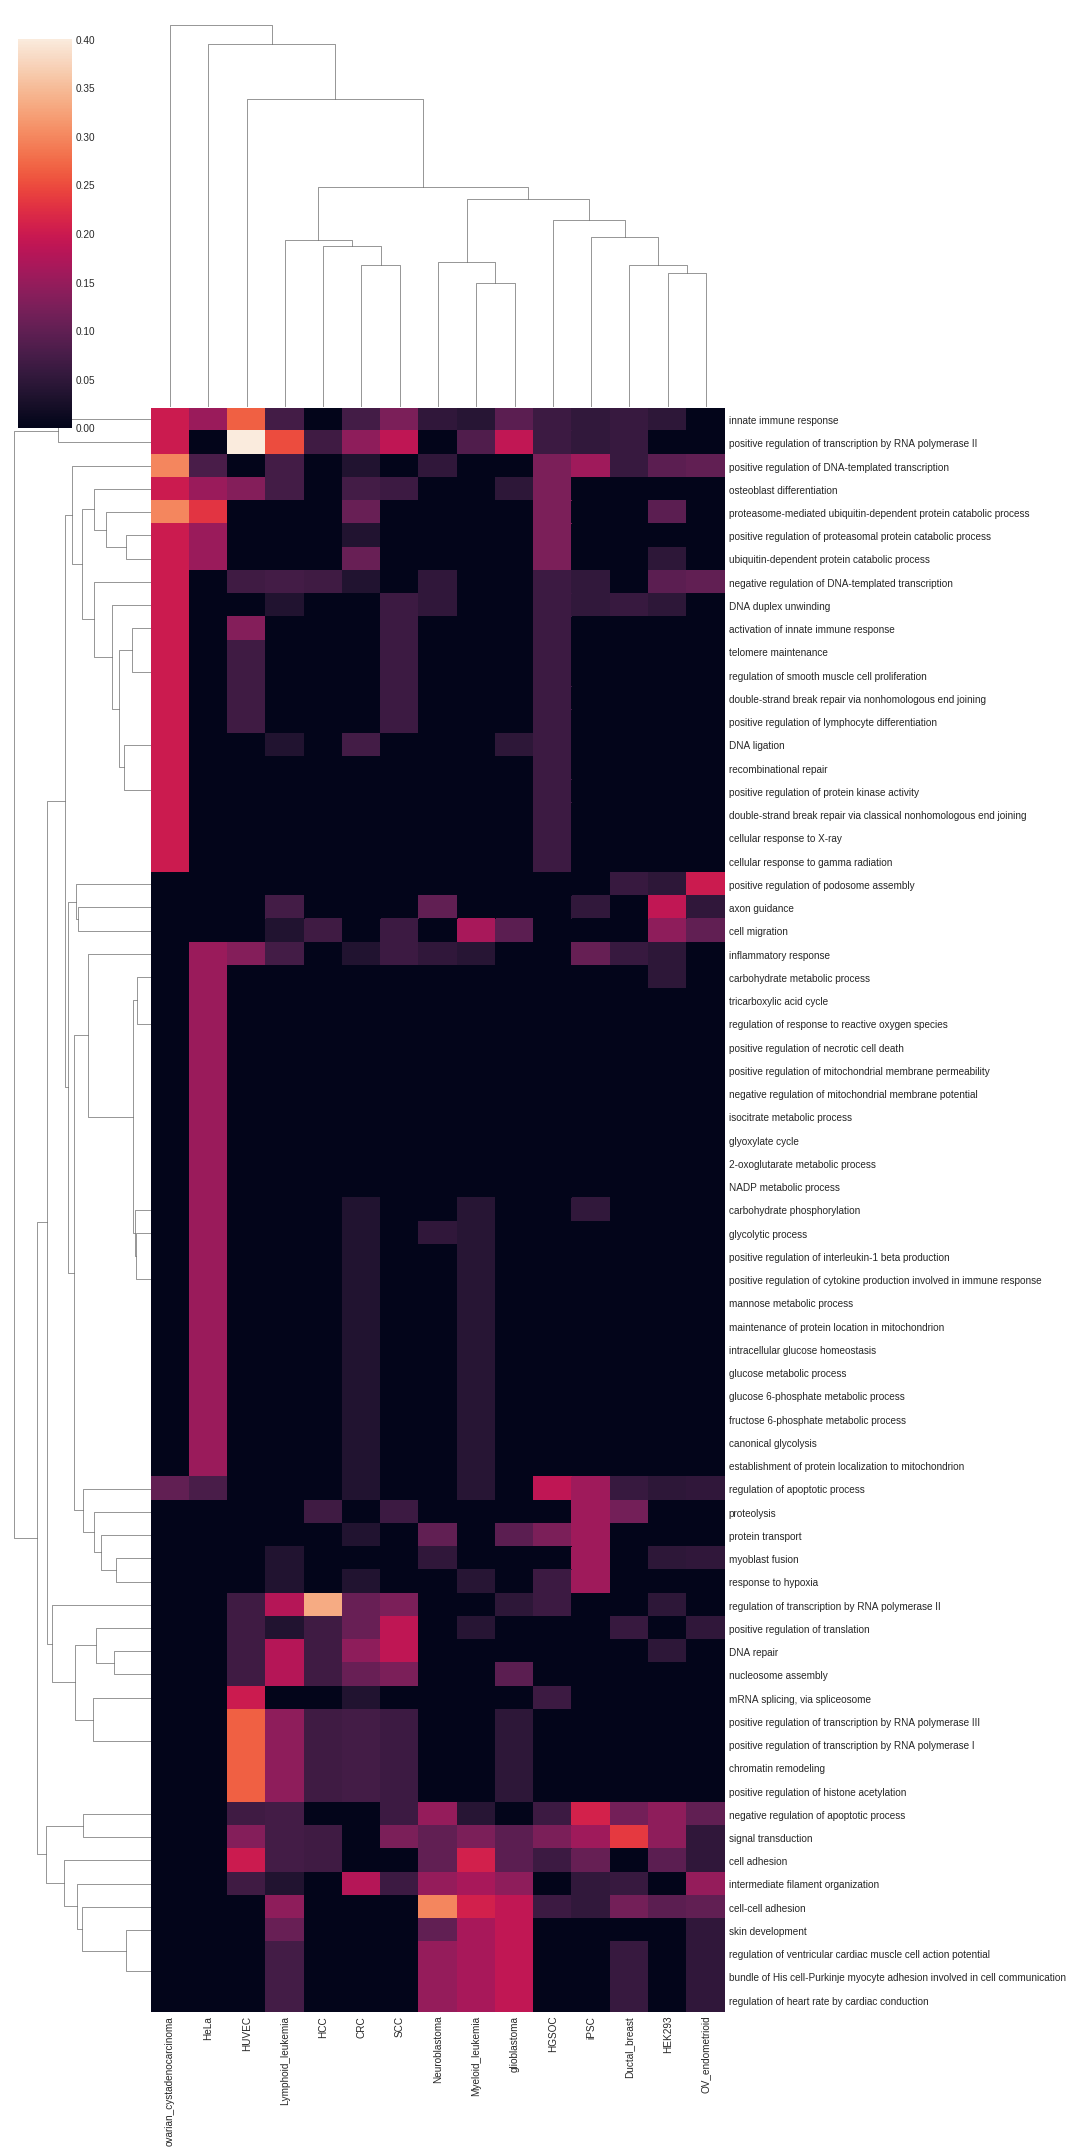

In [220]:
go_per_class_abundant = []
go_per_class_depleted = []

for i, prots in prots_per_class.items():

    ind = target_encoder.transform([i])[0]
    abundant_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank > 7]
    depleted_important_features = combined_shaps[ind].loc[prots].index[combined_shaps[ind].loc[prots].Abundance_rank <= 7]

    go_per_class_abundant.append(calc_go(abundant_important_features, uniprot_go_process, missing_ontology_P).rename(i)/len(abundant_important_features))
    go_per_class_depleted.append(calc_go(depleted_important_features, uniprot_go_process, missing_ontology_P).rename(i)/len(depleted_important_features))

    print(len(abundant_important_features), len(depleted_important_features))

go_per_class_abundant = pd.concat(go_per_class_abundant,axis=1).fillna(0)
go_per_class_depleted = pd.concat(go_per_class_depleted,axis=1).fillna(0)

indices_abundant = go_per_class_abundant.index[(go_per_class_abundant>.15).any(axis=1)]
indices_depleted = go_per_class_depleted.index[(go_per_class_depleted>.15).any(axis=1)]

sns.clustermap(go_per_class_abundant.loc[indices_abundant], figsize=(15,20))
sns.clustermap(go_per_class_depleted.loc[indices_depleted], figsize=(15,30))

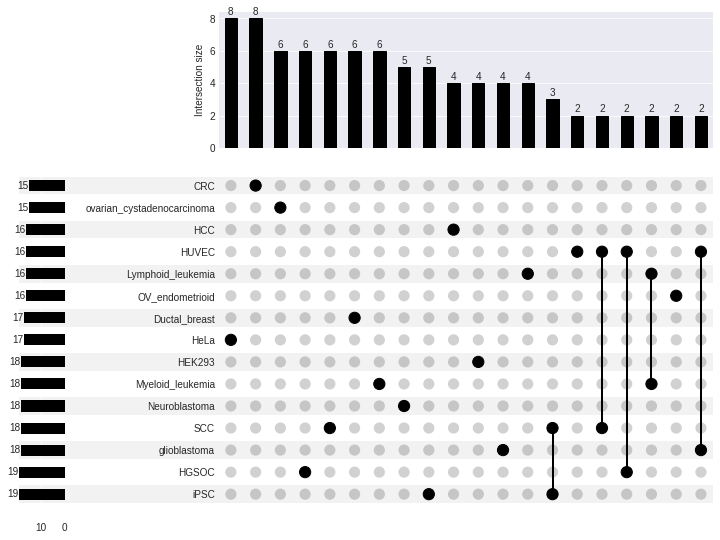

In [115]:
upset_cp = uplt.from_contents(prots_per_class)
uplt.UpSet(upset_cp, min_subset_size=2, show_counts=True, sort_by="cardinality")

In [116]:
def get_unique(dict_class_prots):
    class_specific = {}
    
    class_specific_prots = []
    all_prots = []
    for c, prots in dict_class_prots.items():
        all_prots += prots
    for prot in set(all_prots):
        # If the protein does not occur in more than 2 or 1 classes
        if all_prots.count(prot) < 3:
            class_specific_prots.append(prot)
    
    for c, prots in dict_class_prots.items():
        class_specific[c] = [prot for prot in prots if prot in class_specific_prots]
    return class_specific

In [117]:
ccl_specific_prots = get_unique(prots_per_class)

<BarContainer object of 15 artists>

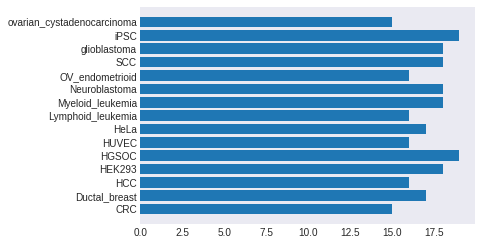

In [119]:
plt.barh(y=list(prots_per_class.keys()), width=[len(x) for x in prots_per_class.values()])

<BarContainer object of 15 artists>

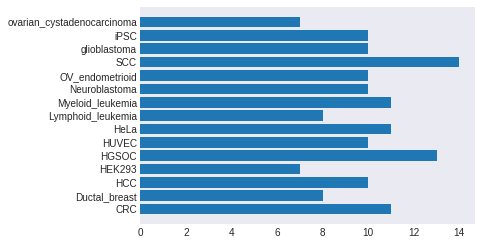

In [120]:
plt.barh(y=list(ccl_specific_prots.keys()), width=[len(x) for x in ccl_specific_prots.values()])

In [125]:
for c, prots in ccl_specific_prots.items():
    print(c)
    for prot in prots:
        print(uniprot_description.loc[prot][0])
    print("___________________")

CRC
E3 ubiquitin-protein ligase RBX1 
CAP-Gly domain-containing linker protein 2 
Scaffold attachment factor B2 
DNA topoisomerase 2-alpha 
Putative nascent polypeptide-associated complex subunit alpha-like protein 
RNA-binding protein 4 
Arf-GAP domain and FG repeat-containing protein 1 
Integrin beta-4 
Stomatin 
Parathymosin
Histone H4
___________________
Ductal_breast
Ethylmalonyl-CoA decarboxylase 
Glutathione S-transferase Mu 3 
Insulin-like growth factor 2 mRNA-binding protein 3 
Cellular retinoic acid-binding protein 2 
Carboxypeptidase D 
Delta-1-pyrroline-5-carboxylate dehydrogenase, mitochondrial 
Carbonyl reductase [NADPH] 3 
Moesin 
___________________
HCC
Dual specificity protein phosphatase 3 
UDP-glucose 6-dehydrogenase 
1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase beta-3 
RNA cytosine C
Echinoderm microtubule-associated protein-like 4 
Aldehyde dehydrogenase, mitochondrial 
Inositol monophosphatase 1 
Glutathione S-transferase Mu 3 
Pyruvate carboxylase, m

---

# Drug targets

In [221]:
columns_thpa = ['Uniprot',
                'Protein class',
                'Gene description',
                'Cell line expression cluster',
                'RNA cell line specificity',
                'RNA cell line distribution',
                'Pathology prognostics - Breast cancer',
                'Pathology prognostics - Cervical cancer',
                'Pathology prognostics - Colorectal cancer',
                'Pathology prognostics - Endometrial cancer',
                'Pathology prognostics - Glioma',
                'Pathology prognostics - Head and neck cancer',
                'Pathology prognostics - Liver cancer',
                'Pathology prognostics - Lung cancer',
                'Pathology prognostics - Melanoma',
                'Pathology prognostics - Ovarian cancer',
                'Pathology prognostics - Pancreatic cancer',
                'Pathology prognostics - Prostate cancer',
                'Pathology prognostics - Renal cancer',
                'Pathology prognostics - Stomach cancer',
                'Pathology prognostics - Testis cancer',
                'Pathology prognostics - Thyroid cancer',
                'Pathology prognostics - Urothelial cancer']

prognostics = ['Pathology prognostics - Breast cancer',
                'Pathology prognostics - Cervical cancer',
                'Pathology prognostics - Colorectal cancer',
                'Pathology prognostics - Endometrial cancer',
                'Pathology prognostics - Glioma',
                'Pathology prognostics - Head and neck cancer',
                'Pathology prognostics - Liver cancer',
                'Pathology prognostics - Lung cancer',
                'Pathology prognostics - Melanoma',
                'Pathology prognostics - Ovarian cancer',
                'Pathology prognostics - Pancreatic cancer',
                'Pathology prognostics - Prostate cancer',
                'Pathology prognostics - Renal cancer',
                'Pathology prognostics - Stomach cancer',
                'Pathology prognostics - Testis cancer',
                'Pathology prognostics - Thyroid cancer',
                'Pathology prognostics - Urothelial cancer']

In [222]:
cancer_related_genes = pd.read_csv("../annotation_files/THPA/cancer_related_genes.tsv", sep="\t", index_col="Uniprot", usecols=columns_thpa)

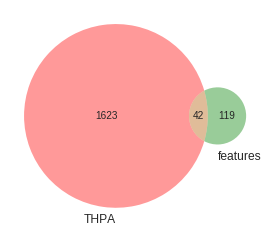

In [224]:
venn.venn2(subsets = (set(cancer_related_genes.index), set(features)), set_labels=("THPA", "features"))

In [225]:
for prot in set(cancer_related_genes.index).intersection(set(features)):
    print(prot)

Q9BZQ8
P26038
Q9UQE7
P62805
O75533
P48735
P08648
P11047
P12270
P14923
P26006
P05783
Q16658
P07948
P23246
P19367
P05787
P16144
Q08211
Q14247
Q14764
P17301
P19174
P32119
Q14116
Q08380
Q9HC35
P46013
P21266
P00338
P04083
Q14676
P78527
P31947
Q9Y5V3
P26447
Q15149
P11388
P12956
Q02952
Q8IVF2
O75475


In [226]:
cancer_related_genes_intersection = list(set(cancer_related_genes.index).intersection(set(features)))
cancer_related_genes = cancer_related_genes.loc[cancer_related_genes_intersection,:]

In [227]:
cancer_related_genes.loc[:,prognostics] = cancer_related_genes.loc[:,prognostics].applymap(lambda x: False if x[:12] == "unprognostic" else x)

In [228]:
prognostics_dict = {}
for prot, row in (cancer_related_genes.loc[:,prognostics] != False).iterrows():
    prognostic_classes = row.index[row]
    
    if len(prognostic_classes) > 0:
        prognostics_dict[prot] = [x.split(" - ")[1] for x in prognostic_classes]

In [229]:
cancer_related_genes = cancer_related_genes.loc[:,~cancer_related_genes.columns.isin(prognostics)]

In [230]:
cancer_related_genes["Cell line expression cluster"].value_counts()

Cluster 60: Keratinocytes - Epithelial cell function           5
Cluster 19: Stomach & Colon cancer - Absorption                4
Cluster 3: HUVEC & TIME - Signal transduction                  4
Cluster 45: Non-specific - Cell proliferation                  2
Cluster 25: Non-specific - Basic cellular processes            2
Cluster 46: Non-specific - Unknown function                    2
Cluster 37: Ovarian cancer RMG-I - Cellular stress response    2
Cluster 22: Rhabdoid cancers - Neuronal signaling              2
Cluster 18: Non-specific - RNA binding                         2
Cluster 54: Lymphoma - Cytokine signaling                      1
Cluster 58: Non-specific - Basic cellular processes            1
Cluster 53: Non-specific - mRNA processing                     1
Cluster 15: Non-specific - Protein binding                     1
Cluster 61: Liver - Metabolism                                 1
Cluster 66: Myeloid cells - Innate immune response             1
Cluster 38: Non-specific 

In [231]:
unique_prognostics_classes = []
for val in prognostics_dict.values():
    for v in val:
        if v not in unique_prognostics_classes:
            unique_prognostics_classes.append(v)
unique_prognostics_classes

['Urothelial cancer',
 'Renal cancer',
 'Cervical cancer',
 'Colorectal cancer',
 'Head and neck cancer',
 'Liver cancer',
 'Lung cancer',
 'Thyroid cancer',
 'Pancreatic cancer',
 'Breast cancer',
 'Melanoma',
 'Endometrial cancer']

In [232]:
def map_thpaPrognostics_to_features(summary):

    prognostic_match = {target_encoder.inverse_transform([i])[0]: {p: [] for p in unique_prognostics_classes} for i in range(15)}

    for i in range(15):
        summary_prots = summary[i].index.tolist()
        
        for summary_prot in summary_prots:
            if summary_prot in prognostics_dict.keys():
                
                for c in prognostics_dict[summary_prot]:
                    prognostic_match[target_encoder.inverse_transform([i])[0]][c].append(summary_prot)

    return prognostic_match

In [233]:
def parse_prognostics(p):
    prot_per_class = {c: [] for c in p.keys()} # Protein identifiers
    disease_per_class = {c: {} for c in p.keys()} # Disease biomarker counts
    
    for class_name, prog_dict in p.items():

        for cancer_type, prots in prog_dict.items():
            if len(prots) != 0:
                for prot in prots:
                    if prot not in prot_per_class[class_name]:
                        prot_per_class[class_name].append(prot)
                disease_per_class[class_name][cancer_type] = len(prots)

    fig, ax1 = plt.subplots(1,1)
    ax1.set_title("# Unique protein prognostics found")
    ax1.barh(y=list(prot_per_class.keys()), width=[len(x) for x in prot_per_class.values()])

    return prot_per_class, disease_per_class

In [237]:
summaries_rf = []
summaries_lr = []
summaries_svc = []


for i in range(15):
    summaries_rf.append(get_summary_df(i, shap_rf_test, y_rf_correct, top_n=20, hard_threshold=False))
    summaries_lr.append(get_summary_df(i, shap_lr_test, y_lr_correct, top_n=20, keep_only_enriched=False))

In [238]:
#svc_prognostics = map_thpaPrognostics_to_features(summaries_svc)
lr_prognostics = map_thpaPrognostics_to_features(summaries_lr_thresh)
rf_prognostics = map_thpaPrognostics_to_features(summaries_rf)

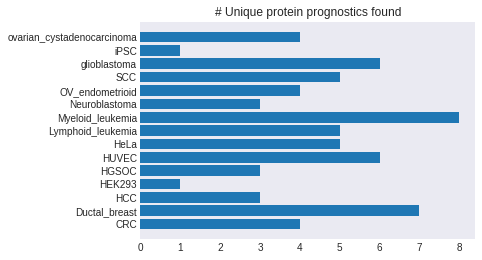

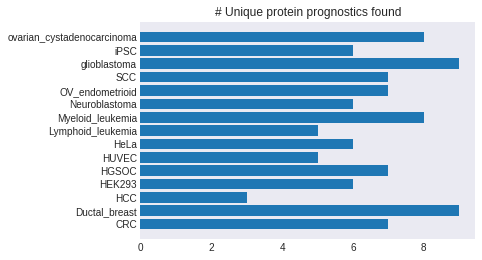

In [239]:
#prognostics_svc, dpc_svc = parse_prognostics(svc_prognostics)
prognostics_lr, dpc_lr = parse_prognostics(lr_prognostics)
prognostics_rf, dpc_rf = parse_prognostics(rf_prognostics)

Let's sum the found prognostics for each model and add importance when one is found by muliple models. Additionally, investigate in the ppi network to what they are linked

In [243]:
def sum_prognostics(lr,rf):
    summed_prognostics_df = pd.DataFrame(columns=list(lr.keys()), index=list(prognostics_dict.keys()))

    for c in summed_prognostics_df.columns:
        prots = lr[c] + rf[c]

        for prot in set(prots):
            summed_prognostics_df.loc[prot,c] = prots.count(prot)
    
    return summed_prognostics_df

In [244]:
summed_prognostics_df = sum_prognostics(prognostics_lr, prognostics_rf)

In [245]:
summed_prognostics_df = summed_prognostics_df.dropna(axis=0, how="all")

In [ ]:
summed_prognostics_df.fillna(0).to_csv("prognostics_string_colorfile.csv")

In [246]:
pd.concat([summed_prognostics_df.loc[:,"CRC"].dropna(), uniprot_description], axis=1, join="inner")

CRC                          description
P62805   2                           Histone H4
P19367   1                        Hexokinase-1 
P16144   2                     Integrin beta-4 
P46013   1  Proliferation marker protein Ki-67 
P21266   1      Glutathione S-transferase Mu 3 
P31947   1                14-3-3 protein sigma 
Q15149   1                             Plectin 
P11388   2           DNA topoisomerase 2-alpha

In [247]:
pd.concat([summed_prognostics_df.loc[:,"SCC"].dropna(), uniprot_description], axis=1, join="inner")

SCC                                        description
Q9BZQ8   2                                   Protein Niban 1 
P08648   1                                  Integrin alpha-5 
P26006   1                                  Integrin alpha-3 
P16144   1                                   Integrin beta-4 
Q08211   1                      ATP-dependent RNA helicase A 
P19174   1  1-phosphatidylinositol 4,5-bisphosphate phosph...
Q14116   2                                    Interleukin-18 
P78527   1    DNA-dependent protein kinase catalytic subunit 
P31947   1                              14-3-3 protein sigma 
Q02952   1                        A-kinase anchor protein 12

'colors' is being deprecated. Please use 'color'instead of 'colors'


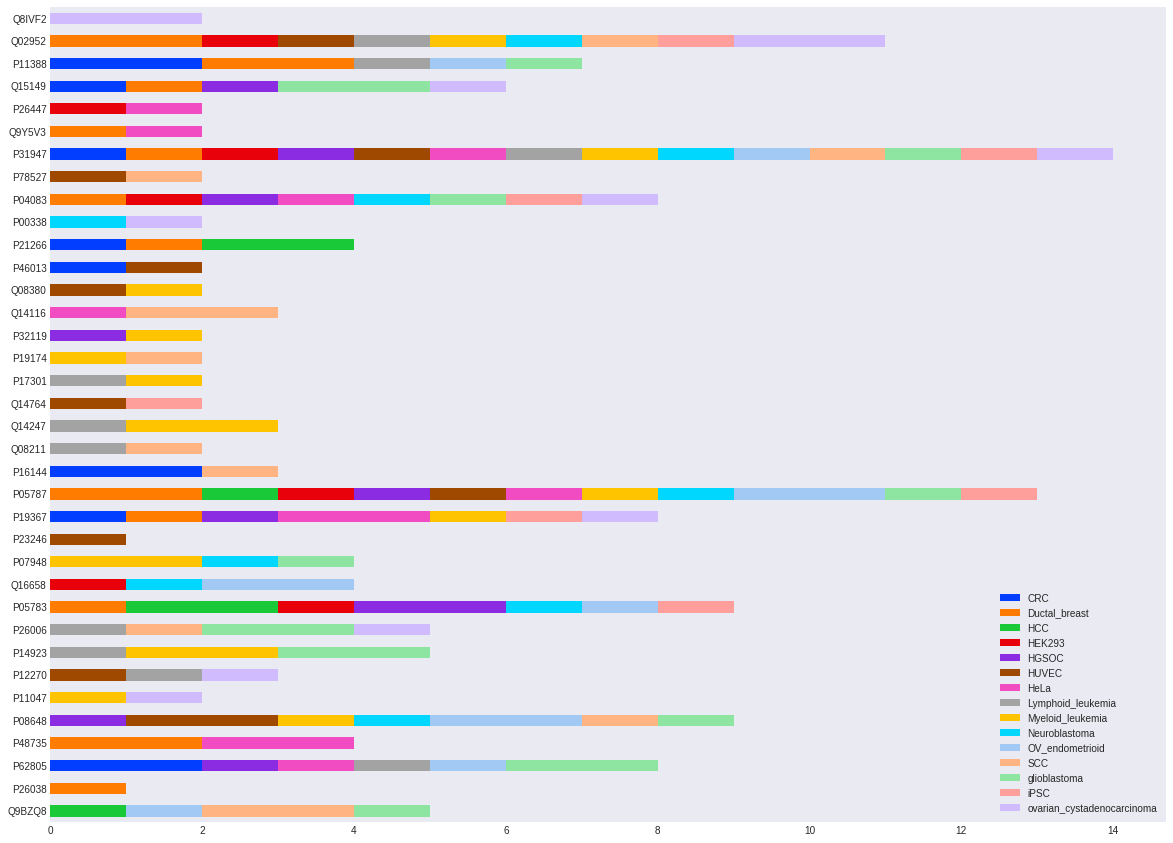

In [248]:
colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]
summed_prognostics_df.plot(kind="barh", stacked=True, figsize=[20,15],colors=colors, )

In [252]:
uniprot_description.loc['Q02952 P31947 P04083 P05787 P05783 P08648 P62805'.split()]

description
uniprot_id                                  
Q02952           A-kinase anchor protein 12 
P31947                 14-3-3 protein sigma 
P04083                           Annexin A1 
P05787      Keratin, type II cytoskeletal 8 
P05783      Keratin, type I cytoskeletal 18 
P08648                     Integrin alpha-5 
P62805                            Histone H4

In [250]:
for keys, values in prognostics_lr.items():
    print(keys,values)

CRC ['P11388', 'P62805', 'P16144', 'P21266']
Ductal_breast ['P11388', 'Q15149', 'P48735', 'Q02952', 'Q9Y5V3', 'P05787', 'P21266']
HCC ['Q9BZQ8', 'P05783', 'P21266']
HEK293 ['P26447']
HGSOC ['P32119', 'P08648', 'P05783']
HUVEC ['Q08380', 'P08648', 'P46013', 'P12270', 'P23246', 'P78527']
HeLa ['P26447', 'P48735', 'Q14116', 'P19367', 'Q9Y5V3']
Lymphoid_leukemia ['P26006', 'Q14247', 'P12270', 'Q08211', 'P17301']
Myeloid_leukemia ['P11047', 'P07948', 'Q08380', 'P14923', 'P32119', 'Q14247', 'P17301', 'P19174']
Neuroblastoma ['P07948', 'P00338', 'P08648']
OV_endometrioid ['Q9BZQ8', 'Q16658', 'P08648', 'P05787']
SCC ['Q9BZQ8', 'Q14116', 'Q08211', 'P16144', 'P19174']
glioblastoma ['Q9BZQ8', 'Q15149', 'P14923', 'P62805', 'P07948', 'P26006']
iPSC ['Q14764']
ovarian_cystadenocarcinoma ['Q8IVF2', 'P11047', 'P26006', 'Q02952']
